# 0. Import Libraries

In [319]:
import azure.functions as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from datetime import date, timedelta
from shared_code import utils
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Initialize Storage Account

In [320]:
azure_utils = utils.AzureUtils()
secret_client = azure_utils.initialize_key_vault()

sa_secret = azure_utils.get_key_vault_secret(secret_client, 'sa-booli')
sa_name = azure_utils.get_key_vault_secret(secret_client, 'sa-name')
storage_account = azure_utils.initialize_storage_account_ad(sa_secret.value, sa_name.value)

# 2. Loading Data

In [321]:
utils_DataFactory = utils.DataFactory()
data_cleaning = utils_DataFactory.get_formatter("Cleaning")

## All objects

In [322]:
columns_to_drop = ["floor", "soldPriceAbsoluteDiff", "soldPricePercentageDiff", "__typename", "listPrice", "rooms", "soldSqmPrice", "livingArea", "rent"]
non_numeric_columns = ["streetAddress", "objectType", "descriptiveAreaName", "soldPriceType", "soldDate", "url", "__typename"]
columns_to_rename = {
    "soldPrice.raw": "soldPriceInSek",
    "floor.raw": "floorNumber",
    "rent.raw": "rentInSek",
    "soldSqmPrice.raw": "soldSqmPriceInSek",
    "soldPriceAbsoluteDiff.raw": "soldPriceVsListPriceDiffInSek",
    "soldPricePercentageDiff.raw": "soldPriceVsListPriceDiffInPercentage",
    "listPrice.raw": "listPriceInSek",
    "livingArea.raw": "livingAreaInSqm",
    "rooms.raw": "numberOfRooms"
}

df = (
    azure_utils.ingest_raw_data("sold/all/Sold_Lägenhet")
    .pipe(data_cleaning.drop_dataframe_columns, columns_to_drop)
    .pipe(data_cleaning.set_dtype_to_numeric, non_numeric_columns)
    .pipe(data_cleaning.change_timestamp_format, "soldDate")
    .pipe(data_cleaning.rename_df_columns, columns_to_rename)
)
df["dateKey"] = df.soldDate.dt.to_period("M")
df.head()

,booliId,streetAddress,constructionYear,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber,dateKey
0,1297209,Drottningholmsvägen 48,2011.0,Lägenhet,St Göran,Slutpris,18.0,2012-11-06,59.332038,18.022488,/bostad/342585,2650000,2193.0,63095.0,0.0,0.0,2650000.0,42.0,2.0,NaN,2012-11
1,1309519,Lilla Västerbron 6,2009.0,Lägenhet,Fredhäll,Slutpris,13.0,2012-11-21,59.331375,18.023321,/annons/1309519,2650000,2989.0,63095.0,150000.0,6.0,2500000.0,42.0,2.0,NaN,2012-11
2,1313807,Igeldammsgatan 20,1932.0,Lägenhet,St Göran,Slutpris,13.0,2012-11-28,59.336983,18.024736,/annons/1313807,2110000,1708.0,57027.0,110000.0,5.5,2000000.0,37.0,1.5,2.0,2012-11
3,1284962,Hjärnegatan 4,NaN,Lägenhet,Kungsholmen,Slutpris,13.0,2012-10-17,59.332541,18.042303,/annons/1284962,2970000,2809.0,54000.0,-30000.0,-1.0,3000000.0,55.0,2.0,4.0,2012-10
4,1282231,Vänskapsvägen 55,NaN,Lägenhet,Stora Essingen,Slutpris,25.0,2012-10-24,59.321561,17.988416,/bostad/792125,2000000,3698.0,41667.0,-200000.0,-9.1,2200000.0,48.0,2.5,3.0,2012-10


## Locations

In [323]:
df_location = pd.read_pickle("addresses.pkl")
df_location.head()


,latitude,longitude,Location,address,amenity,road,suburb,city_district,city,municipality,county,ISO3166-2-lvl4,postcode,country,country_code,house_number,neighbourhood,shop,residential,highway,building,office,leisure,man_made,healthcare,tourism,craft,commercial,railway,historic,club
booliId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
598032,59.334000,18.023153,"(Sankt Görans sjukhus, Thorildsvägen, Kristine...","{'amenity': 'Sankt Görans sjukhus', 'road': 'T...",Sankt Görans sjukhus,Thorildsvägen,Kristineberg,Kungsholmens stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,112 43,Sverige,se,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688449,59.372300,18.055624,"(12, Ekhagsvägen, Ekhagen, Norra Djurgården, Ö...","{'house_number': '12', 'road': 'Ekhagsvägen', ...",NaN,Ekhagsvägen,Norra Djurgården,Östermalms stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,114 18,Sverige,se,12,Ekhagen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692069,59.336461,18.100154,"(6, Gyllenstiernsgatan, Östermalm, Östermalms ...","{'house_number': '6', 'road': 'Gyllenstiernsga...",NaN,Gyllenstiernsgatan,Östermalm,Östermalms stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,115 26,Sverige,se,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
796496,59.340750,18.082264,"(62, Nybrogatan, Villastaden, Östermalm, Öster...","{'house_number': '62', 'road': 'Nybrogatan', '...",NaN,Nybrogatan,Östermalm,Östermalms stadsdelsområde,NaN,Stockholms kommun,Stockholms län,SE-AB,114 49,Sverige,se,62,Villastaden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871388,59.311852,18.069763,"(6, Möregatan, Skanstull, Södermalm, Södermalm...","{'house_number': '6', 'road': 'Möregatan', 'ne...",NaN,Möregatan,Södermalm,Södermalms stadsdelsområde,NaN,Stockholms kommun,Stockholms län,SE-AB,118 58,Sverige,se,6,Skanstull,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [324]:
df_location = df_location[["latitude", "longitude", "suburb"]]
df_location.head()

,latitude,longitude,suburb
booliId,,,
598032,59.334000,18.023153,Kristineberg
688449,59.372300,18.055624,Norra Djurgården
692069,59.336461,18.100154,Östermalm
796496,59.340750,18.082264,Östermalm
871388,59.311852,18.069763,Södermalm


## Inflation

In [325]:
df_inflation = pd.read_pickle("CPITotal.pkl").reset_index()
df_inflation["dateKey"] = df_inflation["key"].dt.to_period("M")
df_inflation = df_inflation.iloc[:, [3,4]]
df_inflation.columns = ["CPIF", "dateKey"]

## Mergin dataframes

In [326]:
df = df.merge(df_inflation, on = "dateKey", how = "left").merge(df_location, on = ["latitude", "longitude"], how = "left")

del df_inflation, df_location

In [327]:
df.head()

,booliId,streetAddress,constructionYear,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber,dateKey,CPIF,suburb
0,1297209,Drottningholmsvägen 48,2011.0,Lägenhet,St Göran,Slutpris,18.0,2012-11-06,59.332038,18.022488,/bostad/342585,2650000,2193.0,63095.0,0.0,0.0,2650000.0,42.0,2.0,NaN,2012-11,0.8,Stadshagen
1,1309519,Lilla Västerbron 6,2009.0,Lägenhet,Fredhäll,Slutpris,13.0,2012-11-21,59.331375,18.023321,/annons/1309519,2650000,2989.0,63095.0,150000.0,6.0,2500000.0,42.0,2.0,NaN,2012-11,0.8,Marieberg
2,1313807,Igeldammsgatan 20,1932.0,Lägenhet,St Göran,Slutpris,13.0,2012-11-28,59.336983,18.024736,/annons/1313807,2110000,1708.0,57027.0,110000.0,5.5,2000000.0,37.0,1.5,2.0,2012-11,0.8,Kungsholmen
3,1284962,Hjärnegatan 4,NaN,Lägenhet,Kungsholmen,Slutpris,13.0,2012-10-17,59.332541,18.042303,/annons/1284962,2970000,2809.0,54000.0,-30000.0,-1.0,3000000.0,55.0,2.0,4.0,2012-10,1.1,Kungsholmen
4,1282231,Vänskapsvägen 55,NaN,Lägenhet,Stora Essingen,Slutpris,25.0,2012-10-24,59.321561,17.988416,/bostad/792125,2000000,3698.0,41667.0,-200000.0,-9.1,2200000.0,48.0,2.5,3.0,2012-10,1.1,Stora Essingen


# 3. General Statistics of the Dataframe

## Data Types

In [328]:
data_cleaning.get_data_types(df)

,Data Type
booliId,int64
streetAddress,object
constructionYear,float64
objectType,object
descriptiveAreaName,object
soldPriceType,object
daysActive,float64
soldDate,datetime64[ns]
latitude,float64
longitude,float64


## Statistical Overview

In [329]:
df.describe()

,booliId,constructionYear,daysActive,latitude,longitude,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber,CPIF
count,9.796900e+04,89247.000000,97373.000000,97969.000000,97969.000000,9.796900e+04,96747.000000,97819.000000,9.415800e+04,9.415800e+04,9.417100e+04,97819.000000,97720.000000,88425.000000,95427.000000
mean,3.173375e+06,1934.465965,21.561737,59.331975,18.052985,5.477869e+06,2743.117740,92867.544209,4.196012e+05,1.443828e+03,4.986828e+06,59.327631,2.274847,2.999138,2.298942
std,1.161990e+06,37.218421,39.639083,0.013098,0.027942,3.448353e+06,1272.563523,21535.623466,5.291770e+05,4.399515e+05,3.192672e+06,30.260140,1.022664,2.154147,2.452268
min,-1.015519e+07,1300.000000,0.000000,59.279156,17.873617,4.000000e+04,1.000000,10000.000000,-6.029043e+06,-7.430000e+01,0.000000e+00,9.400000,1.000000,-3.000000,-0.400000
25%,2.070230e+06,1912.000000,11.000000,59.318610,18.033279,3.350000e+06,1866.000000,78395.000000,1.000000e+05,2.100000e+00,2.995000e+06,38.000000,2.000000,1.500000,0.900000
50%,3.330331e+06,1930.000000,13.000000,59.334994,18.051447,4.500000e+06,2491.000000,91429.000000,3.550000e+05,9.200000e+00,3.995000e+06,53.000000,2.000000,3.000000,1.600000
75%,4.150658e+06,1942.000000,19.000000,59.342280,18.077690,6.510000e+06,3391.000000,105378.000000,6.300000e+05,1.620000e+01,5.995000e+06,74.000000,3.000000,4.000000,2.200000
max,4.858366e+06,2023.000000,2832.000000,59.373271,18.142138,1.350000e+08,35803.000000,755556.000000,1.500000e+07,1.349999e+08,7.500000e+07,970.000000,19.000000,99.900000,9.700000


## Missing Values

In [330]:
def get_missing_values_percent(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    dropped_columns = missing_data[missing_data.Percent >= 0.5].index
    print(missing_data)

In [331]:
get_missing_values_percent(df)

                                      Total   Percent
floorNumber                            9544  0.097419
constructionYear                       8722  0.089028
soldPriceVsListPriceDiffInPercentage   3811  0.038900
soldPriceVsListPriceDiffInSek          3811  0.038900
listPriceInSek                         3798  0.038767
CPIF                                   2542  0.025947
rentInSek                              1222  0.012473
suburb                                 1114  0.011371
daysActive                              596  0.006084
numberOfRooms                           249  0.002542
soldSqmPriceInSek                       150  0.001531
livingAreaInSqm                         150  0.001531
dateKey                                   0  0.000000
booliId                                   0  0.000000
streetAddress                             0  0.000000
url                                       0  0.000000
longitude                                 0  0.000000
latitude                    

# 4. Data Visualization

## Distributions

In [332]:
def plot_distribution(dataframe, column, ax, bins_ = 100):
    dataframe[column].plot(kind = "hist", bins = bins_, ax = ax, color = "lightblue", ec = "black", linewidth = 1)
    
    min_ylim, max_ylim = ax.get_ylim()
    mean = dataframe[column].mean()
    std = dataframe[column].std()
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()
    ax.set_xlabel(column)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.ticklabel_format(style = "plain", axis = "x")
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    ax.axvline(mean, color = "k", linestyle = "--", linewidth = 1)
    ax.set_title("Histogram of {}: $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(column, mean, std))

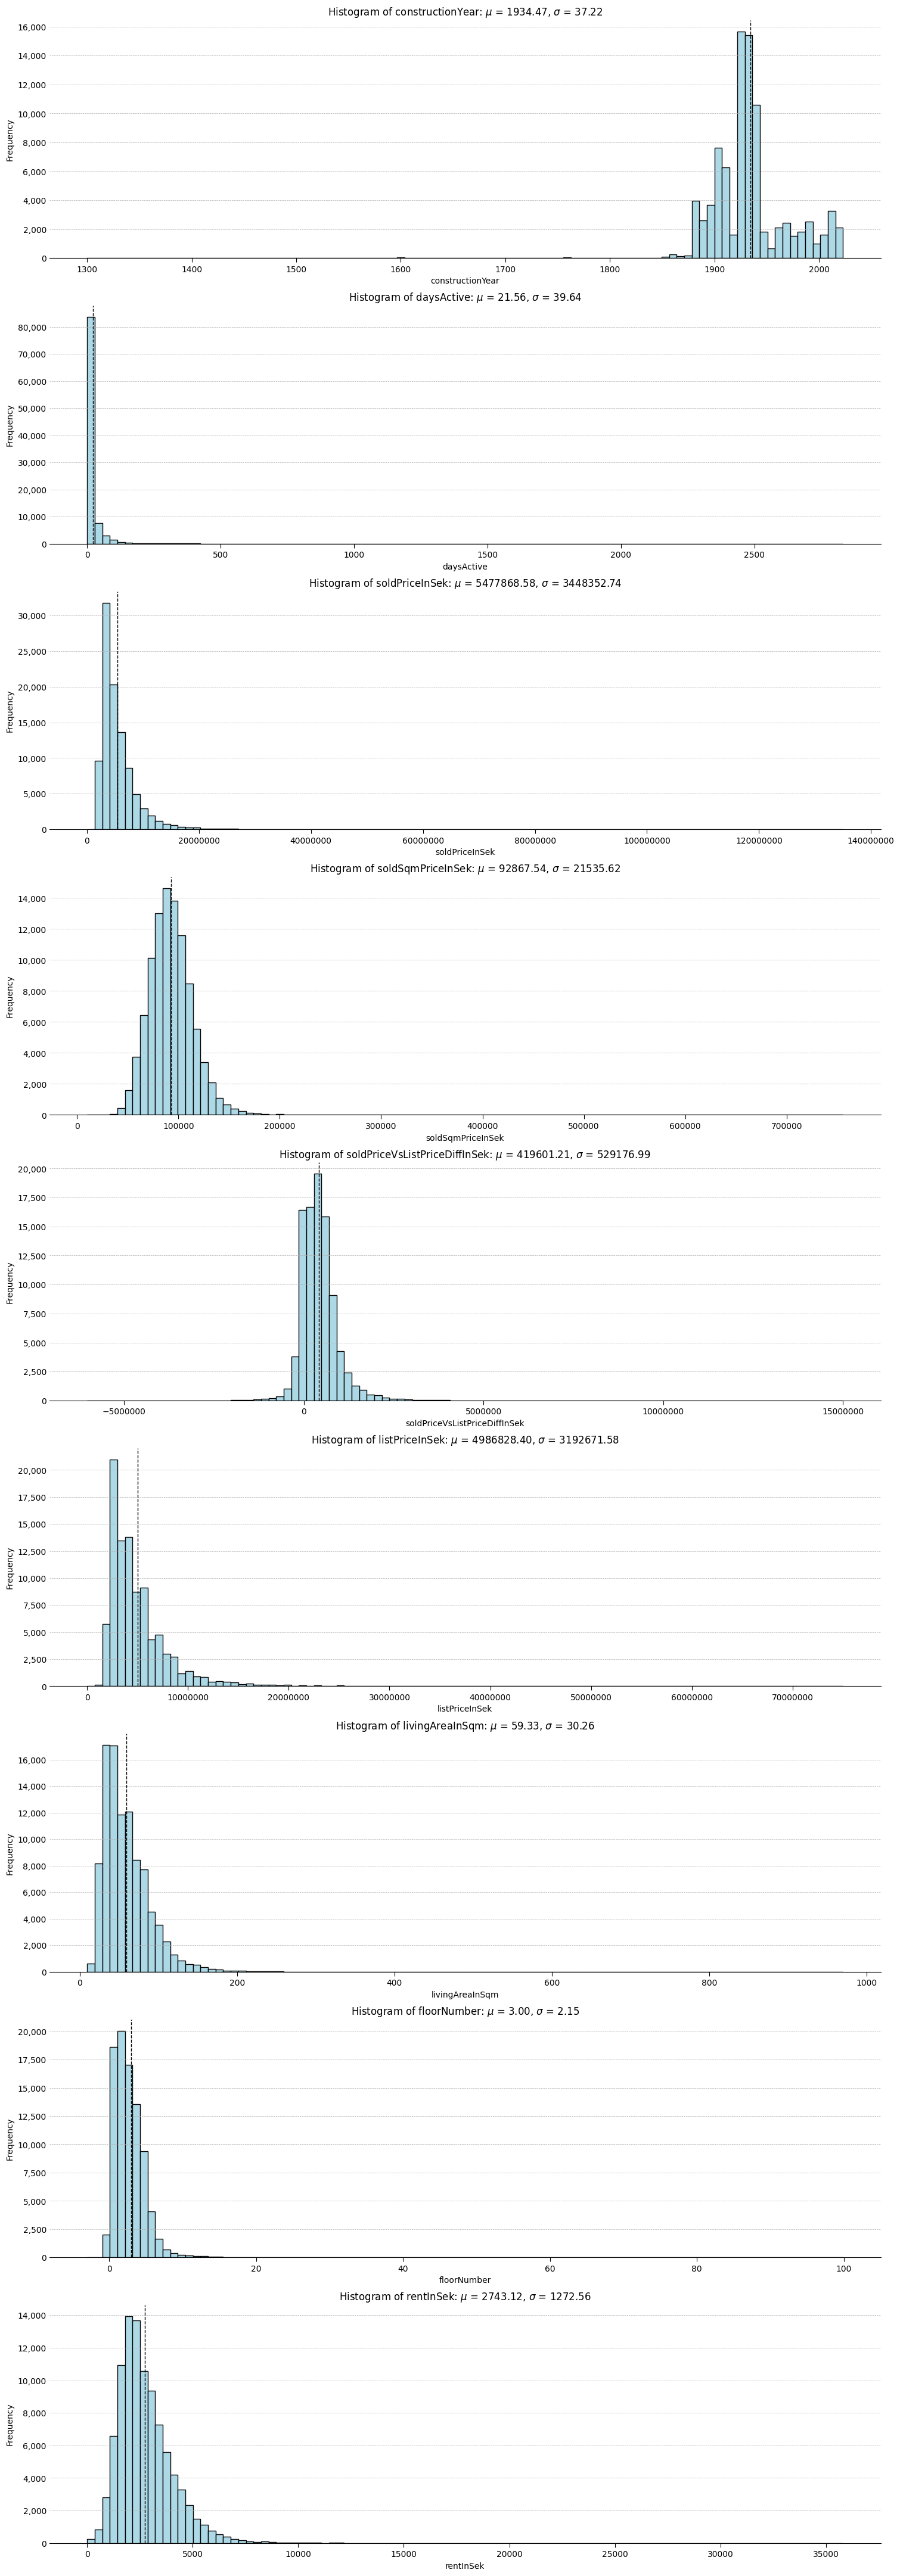

In [333]:
fig, axs = plt.subplots(nrows = 9, figsize = (18,55))

plot_distribution(df, "constructionYear", axs[0])
plot_distribution(df, "daysActive", axs[1])
plot_distribution(df, "soldPriceInSek", axs[2])
plot_distribution(df, "soldSqmPriceInSek", axs[3])
plot_distribution(df, "soldPriceVsListPriceDiffInSek", axs[4])
plot_distribution(df, "listPriceInSek", axs[5])
plot_distribution(df, "livingAreaInSqm", axs[6])
plot_distribution(df, "floorNumber", axs[7])
plot_distribution(df, "rentInSek", axs[8])

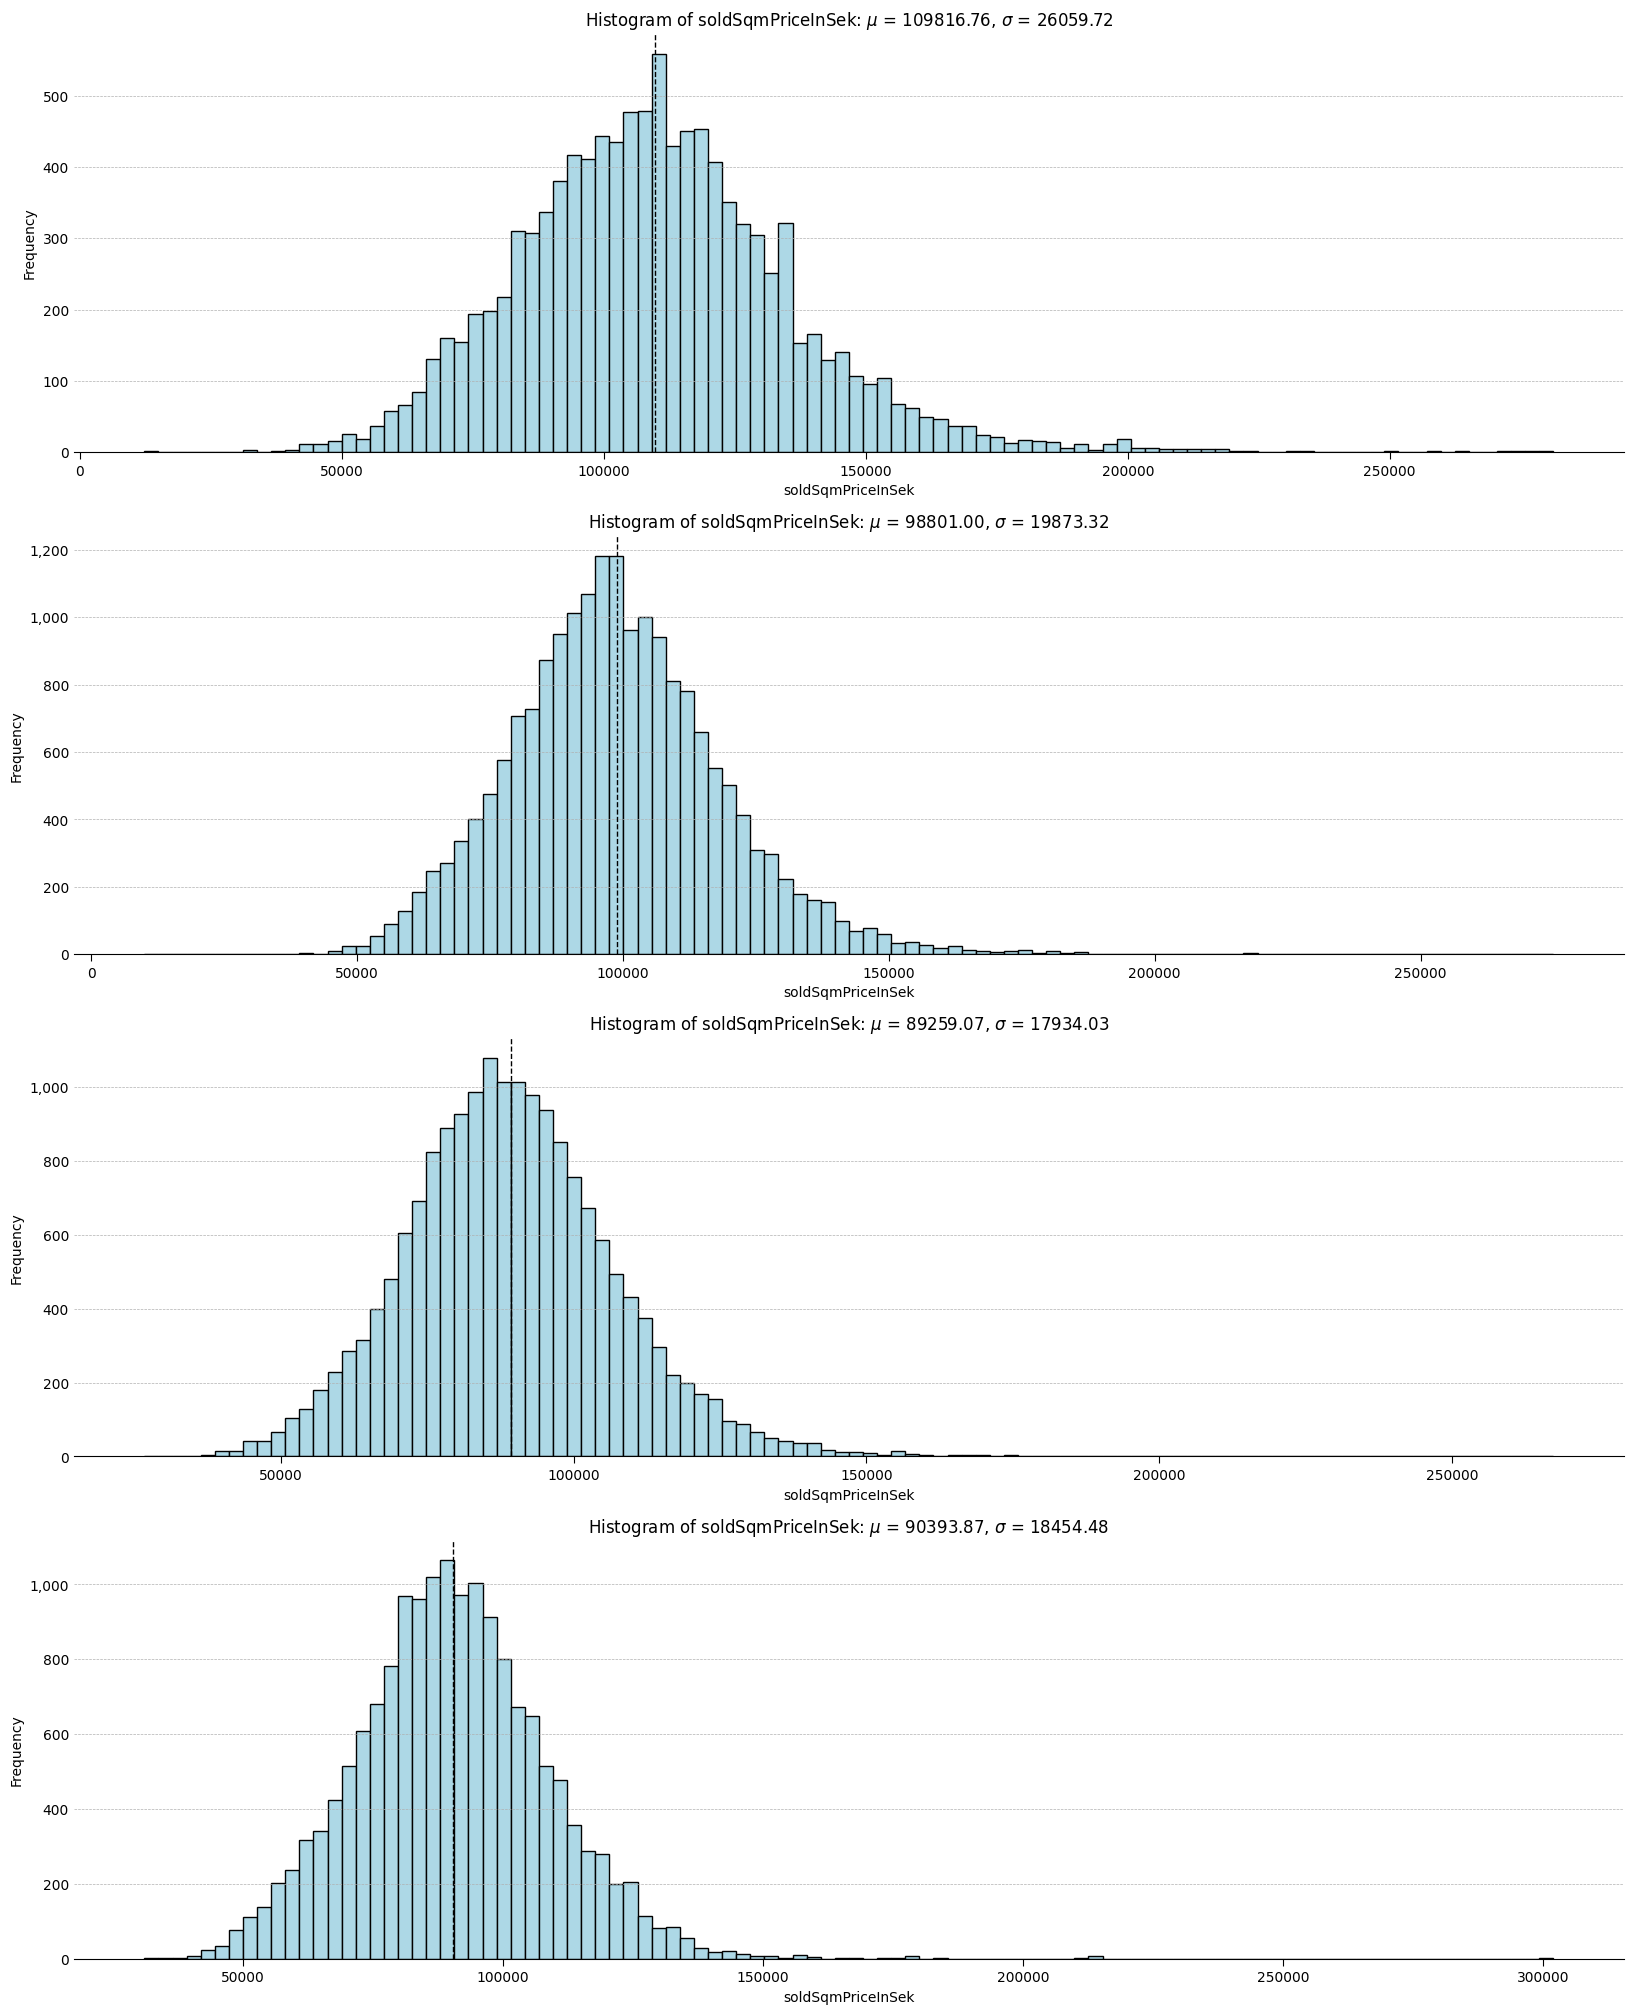

In [232]:
fig, axs = plt.subplots(nrows = 4, figsize = (20,25))
plot_distribution(df[df.descriptiveAreaName == "Östermalm"], "soldSqmPriceInSek", axs[0])
plot_distribution(df[df.descriptiveAreaName == "Vasastan"], "soldSqmPriceInSek", axs[1])
plot_distribution(df[df.descriptiveAreaName == "Kungsholmen"], "soldSqmPriceInSek", axs[2])
plot_distribution(df[df.descriptiveAreaName == "Södermalm"], "soldSqmPriceInSek", axs[3])

## Features by Sold Date and Listing Date

In [233]:
def plot_dates(dataframe, date_col, measure_col, agg_func = "count"):
    if agg_func == "count":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).count()
    elif agg_func == "sum":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).sum()
    elif agg_func == "mean":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).mean()
    else:
        return print("Choose a correct aggregation function")
        
    ax = temp.plot(kind = "line", figsize = (25, 10))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    plt.show()

### Sold Objects

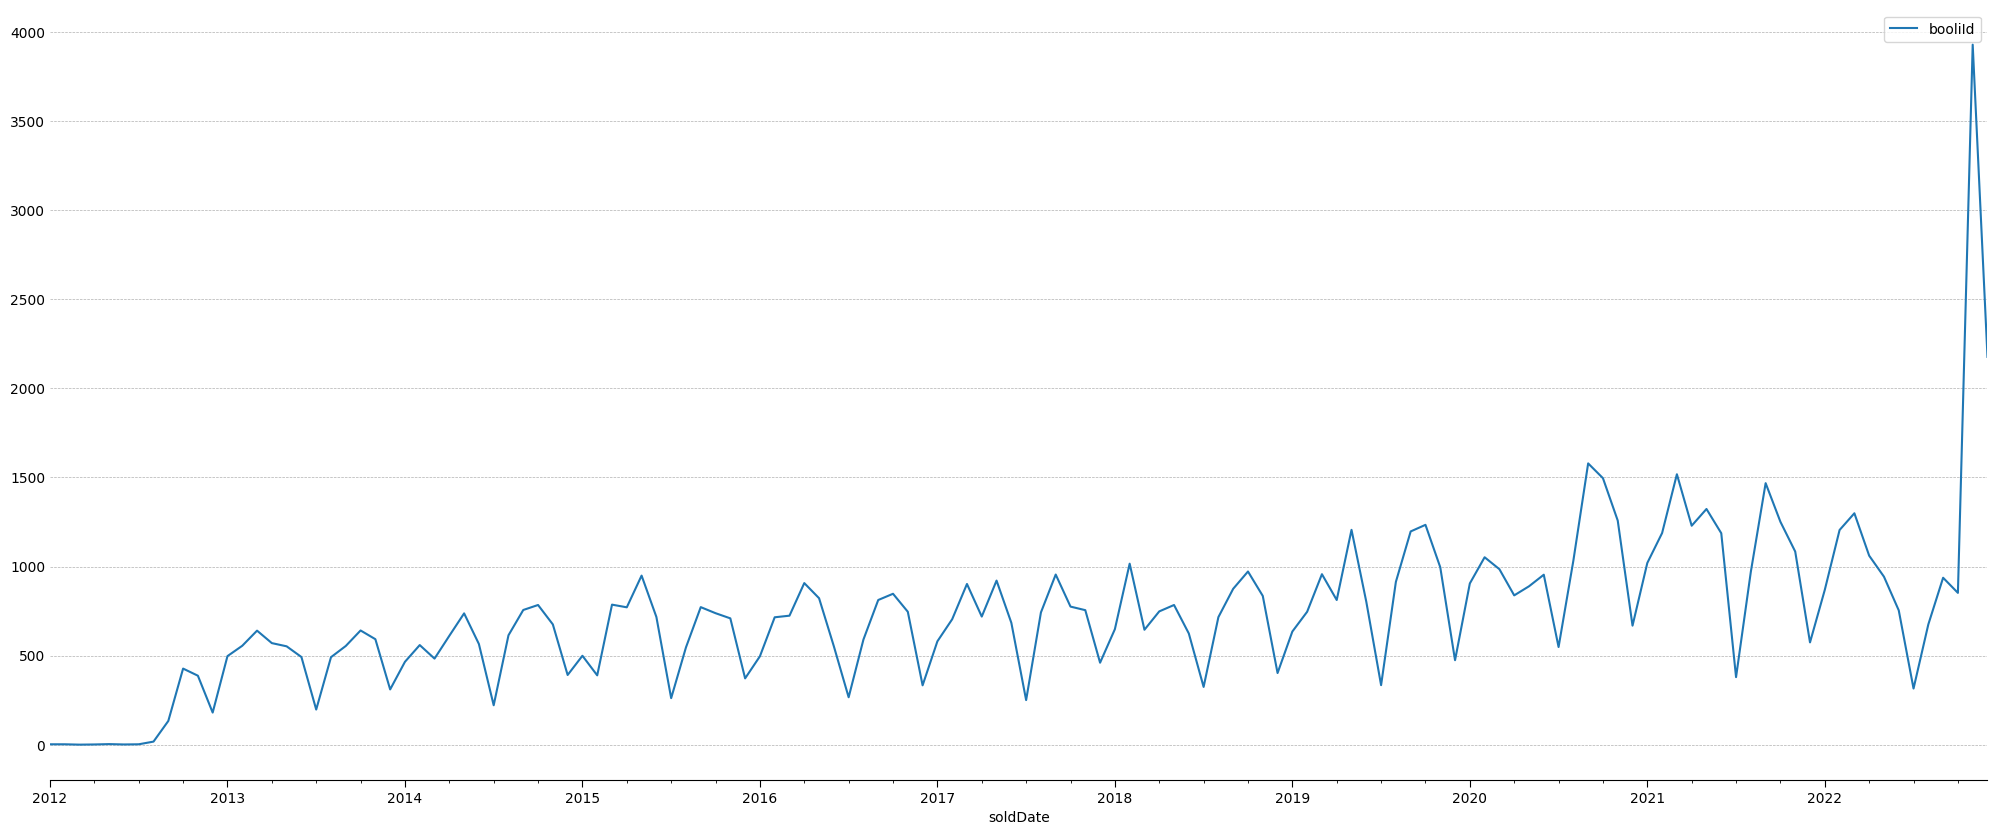

In [234]:
df["soldDate"] = pd.to_datetime(df["soldDate"], format = "%Y-%m-%d")
plot_dates(df, "soldDate", "booliId", "count")

### Object per Listing Month

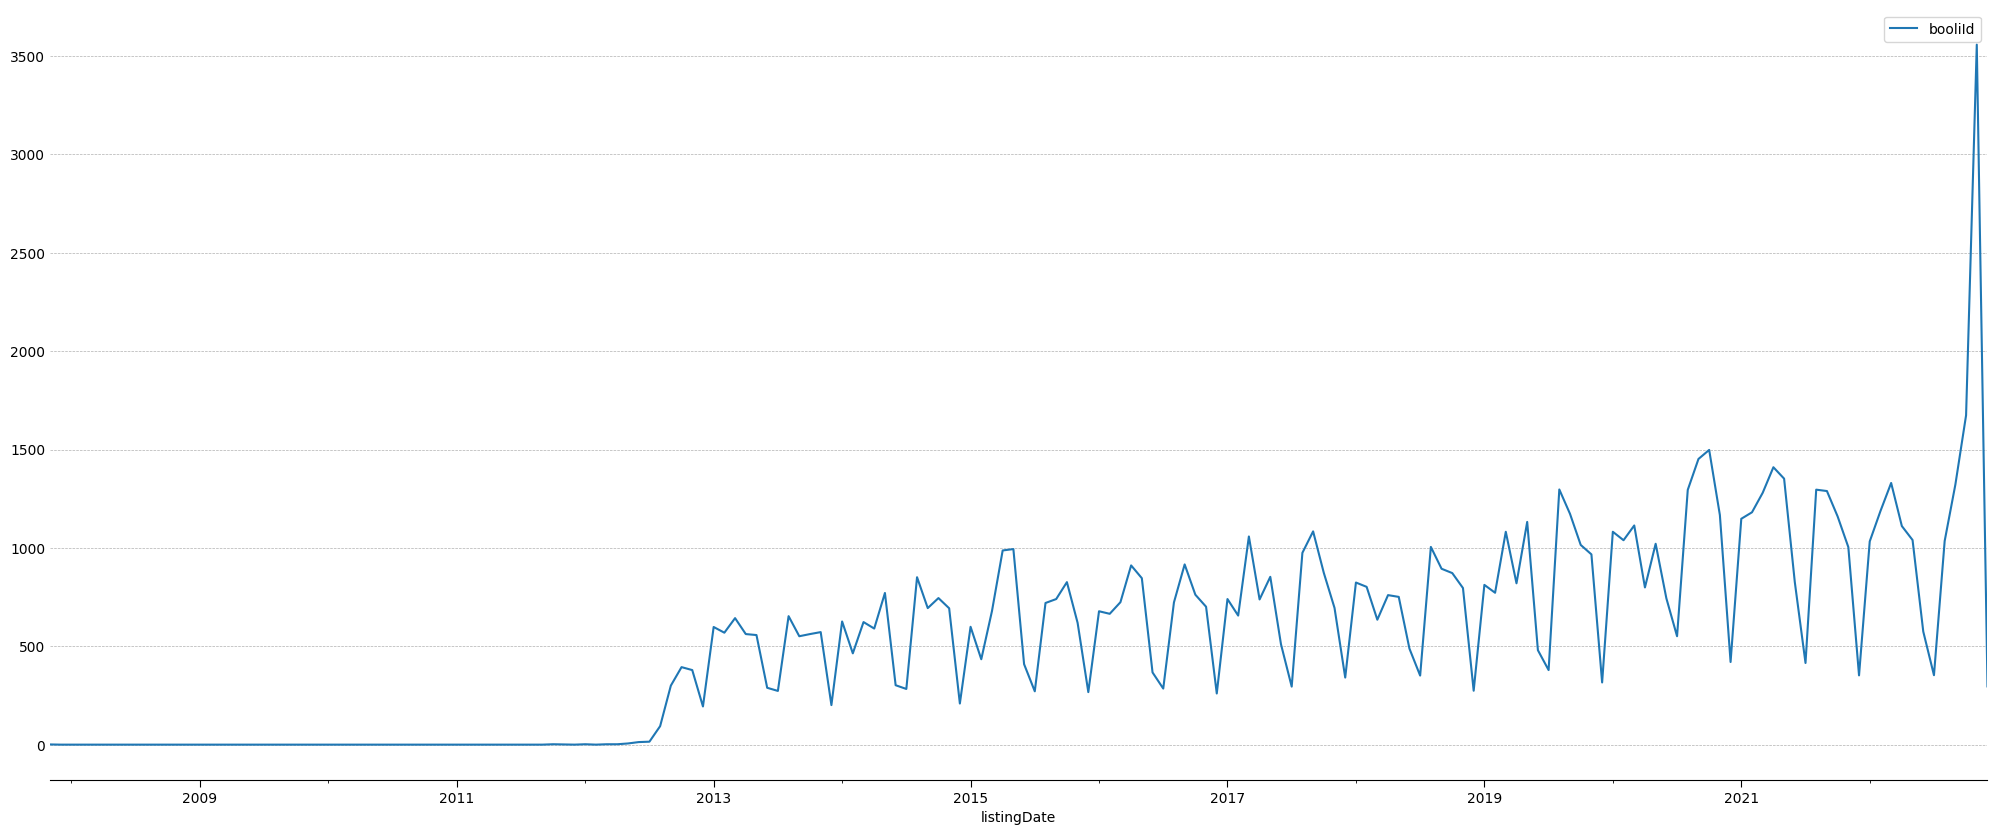

In [235]:
df_listingMonth = df.copy()
df_listingMonth = df_listingMonth[~(df_listingMonth.soldDate.isnull() | df_listingMonth.daysActive.isnull())]
df_listingMonth["listingDate"] = df_listingMonth.soldDate - pd.to_timedelta(df.daysActive, unit = "d")
plot_dates(df_listingMonth, "listingDate", "booliId", "count")

### Average Listings per Month

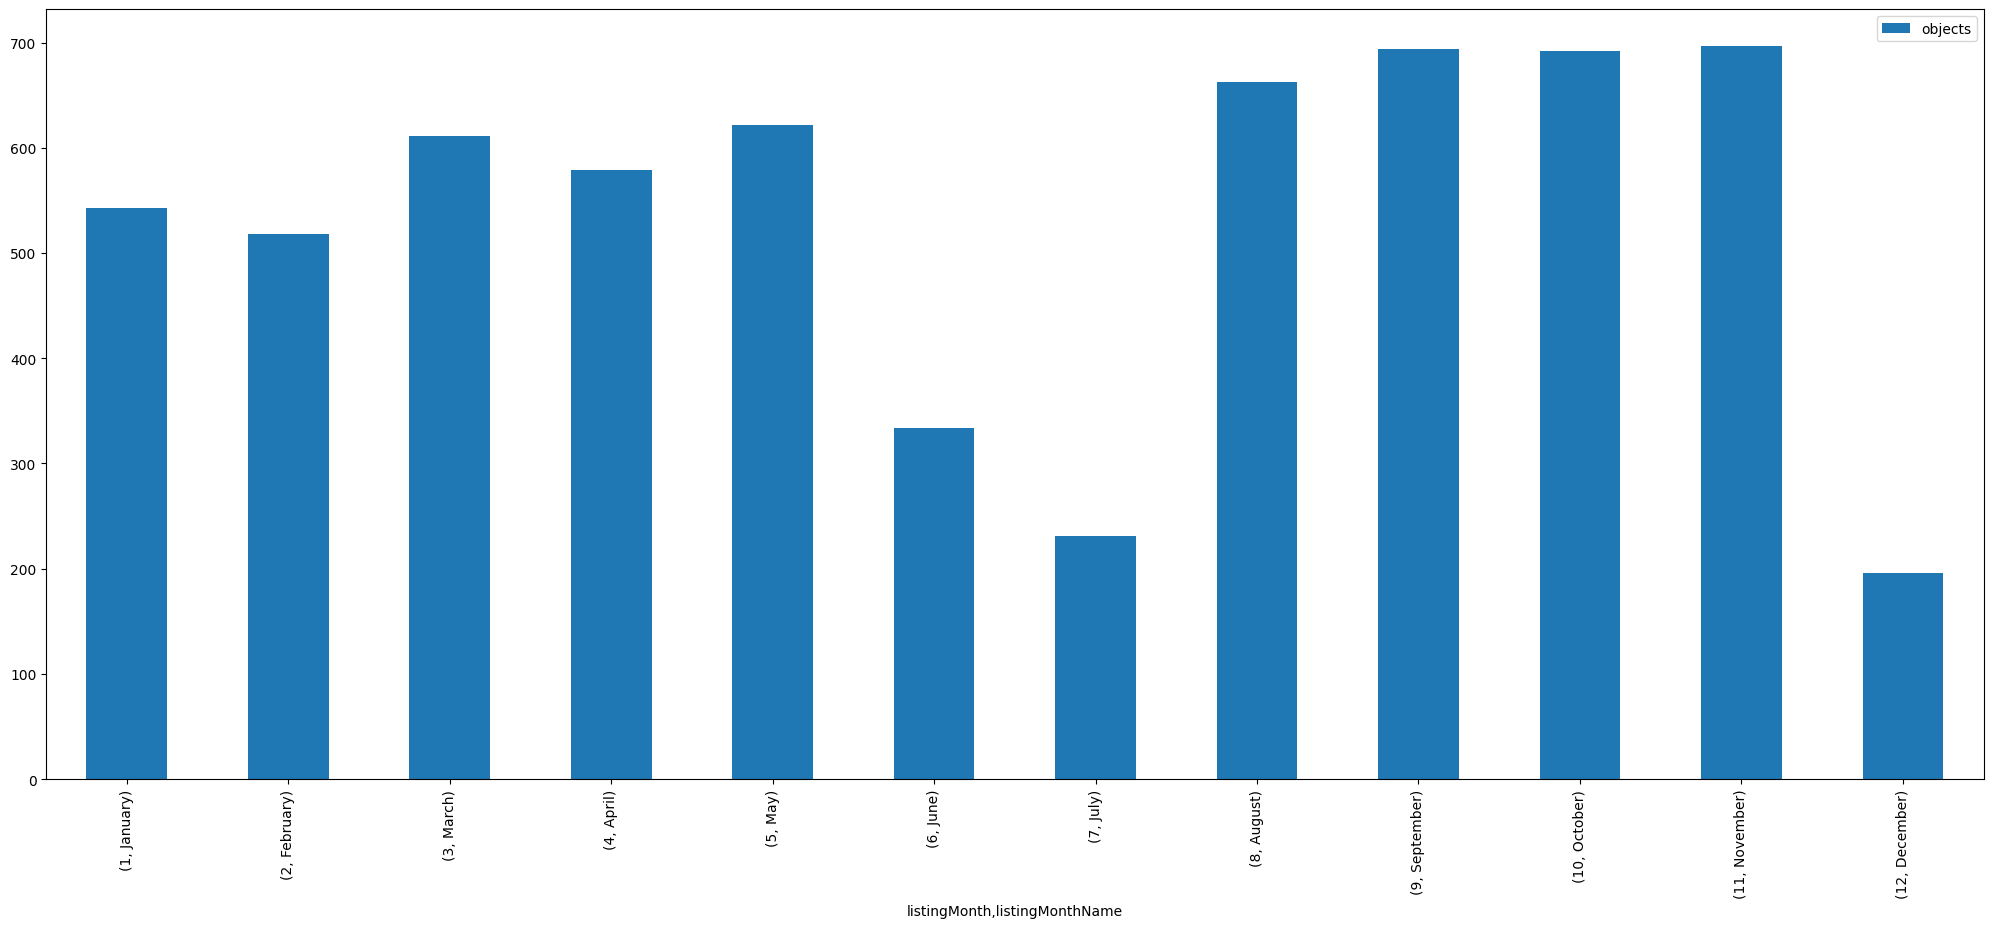

In [236]:

df_listingMonth = df_listingMonth[["listingDate", "booliId"]].set_index("listingDate").groupby([pd.Grouper(freq = "M")]).count().reset_index().rename(columns = {"booliId" : "objects"})
df_listingMonth["listingMonthName"] = pd.to_datetime(df_listingMonth.listingDate).dt.month_name()
df_listingMonth["listingMonth"] = pd.to_datetime(df_listingMonth.listingDate).dt.month
df_listingMonth = df_listingMonth.sort_values(by = "listingMonth", ascending = True)
df_listingMonth = df_listingMonth[["listingMonth", "listingMonthName", "objects"]].groupby(["listingMonth", "listingMonthName"]).mean()
df_listingMonth.plot(kind = "bar", figsize = (25, 10))

del df_listingMonth

### Mean Days Active

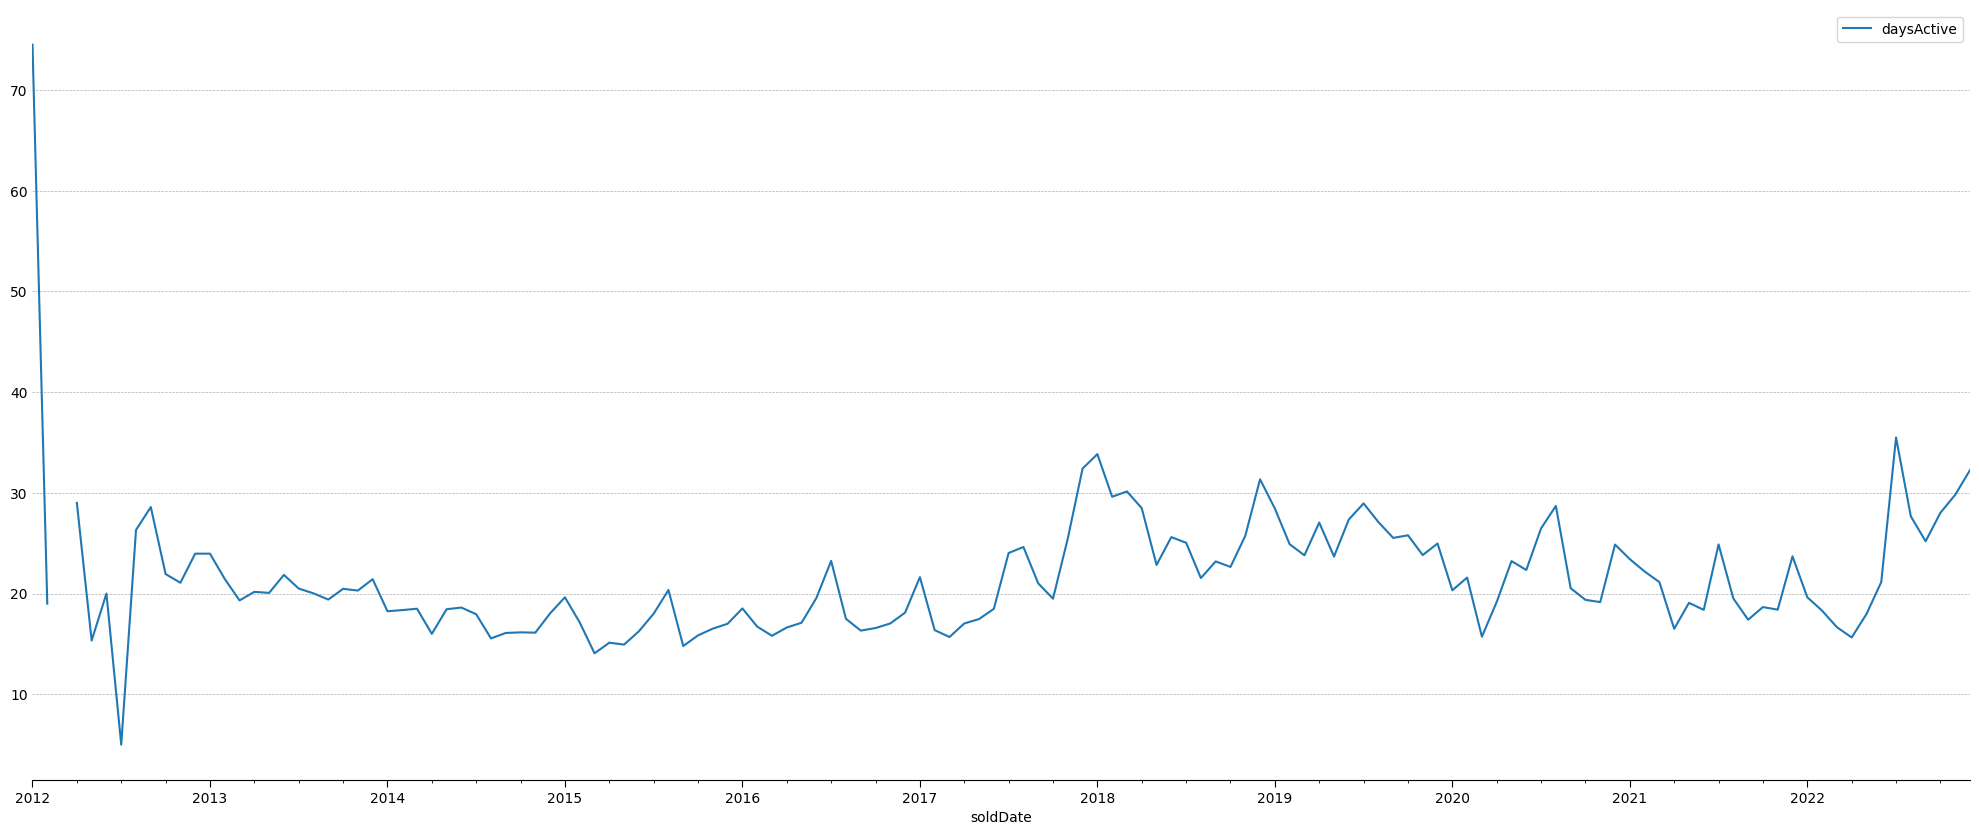

In [237]:
plot_dates(df, "soldDate", "daysActive", "mean")

### Mean Sold Sqm Price in Sek

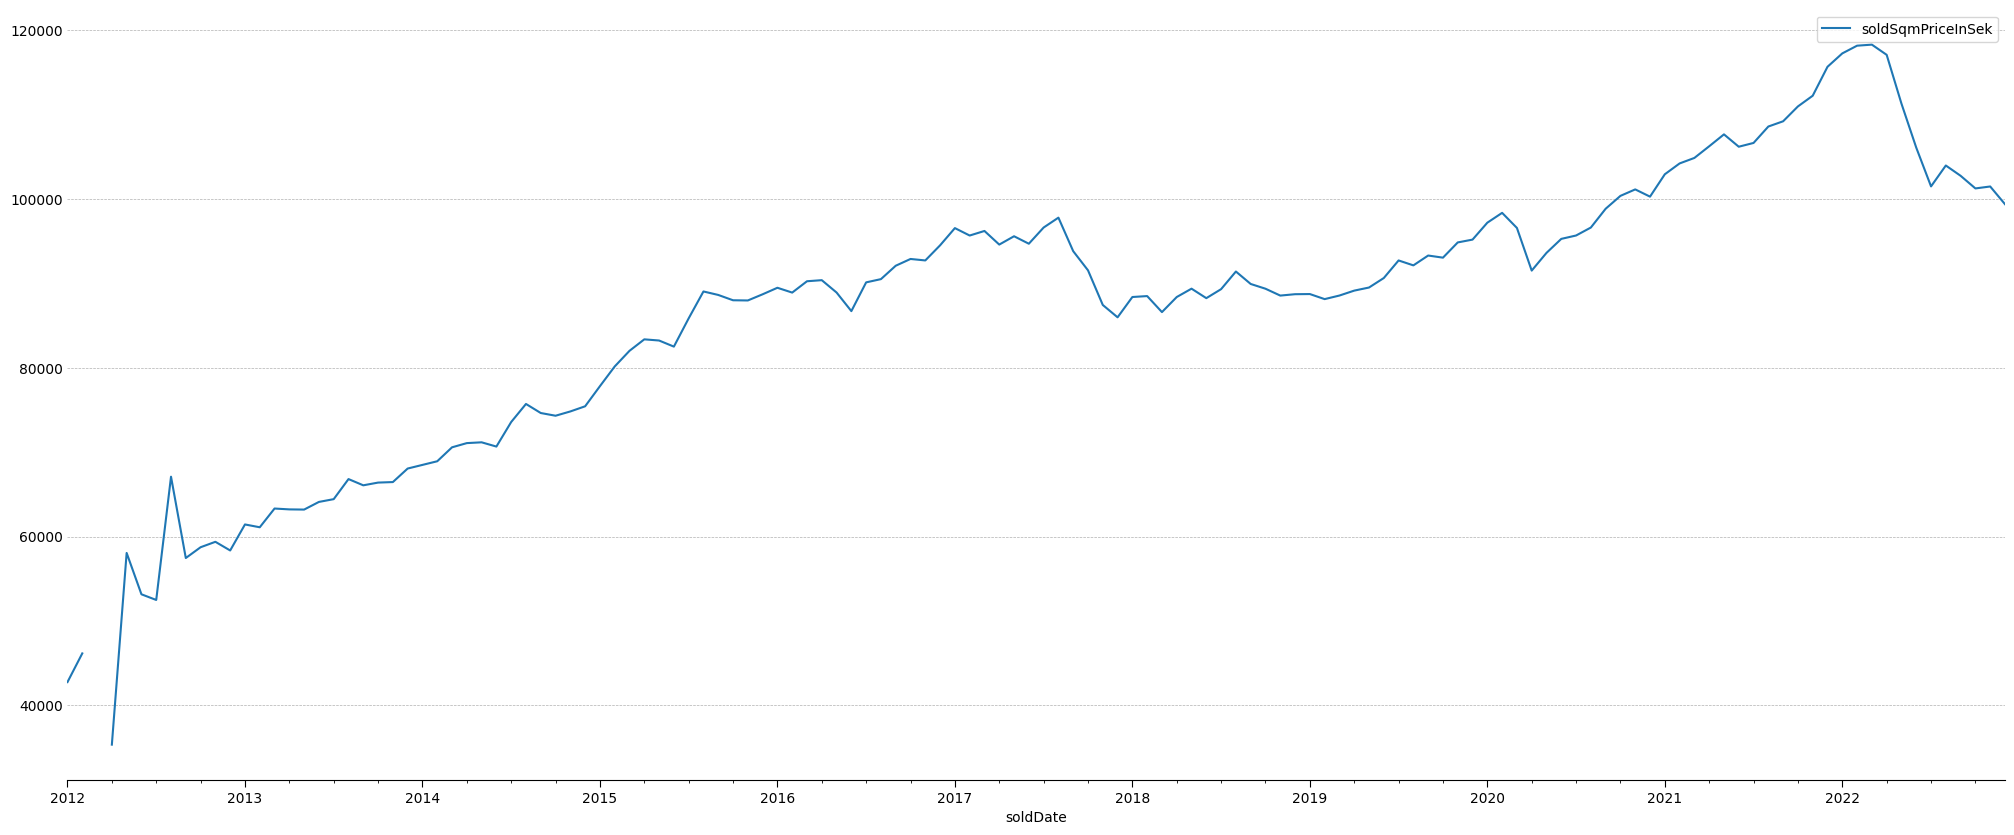

In [238]:
plot_dates(df, "soldDate", "soldSqmPriceInSek", "mean")

### Mean Sold Sqm Price in Sek per Number of Rooms

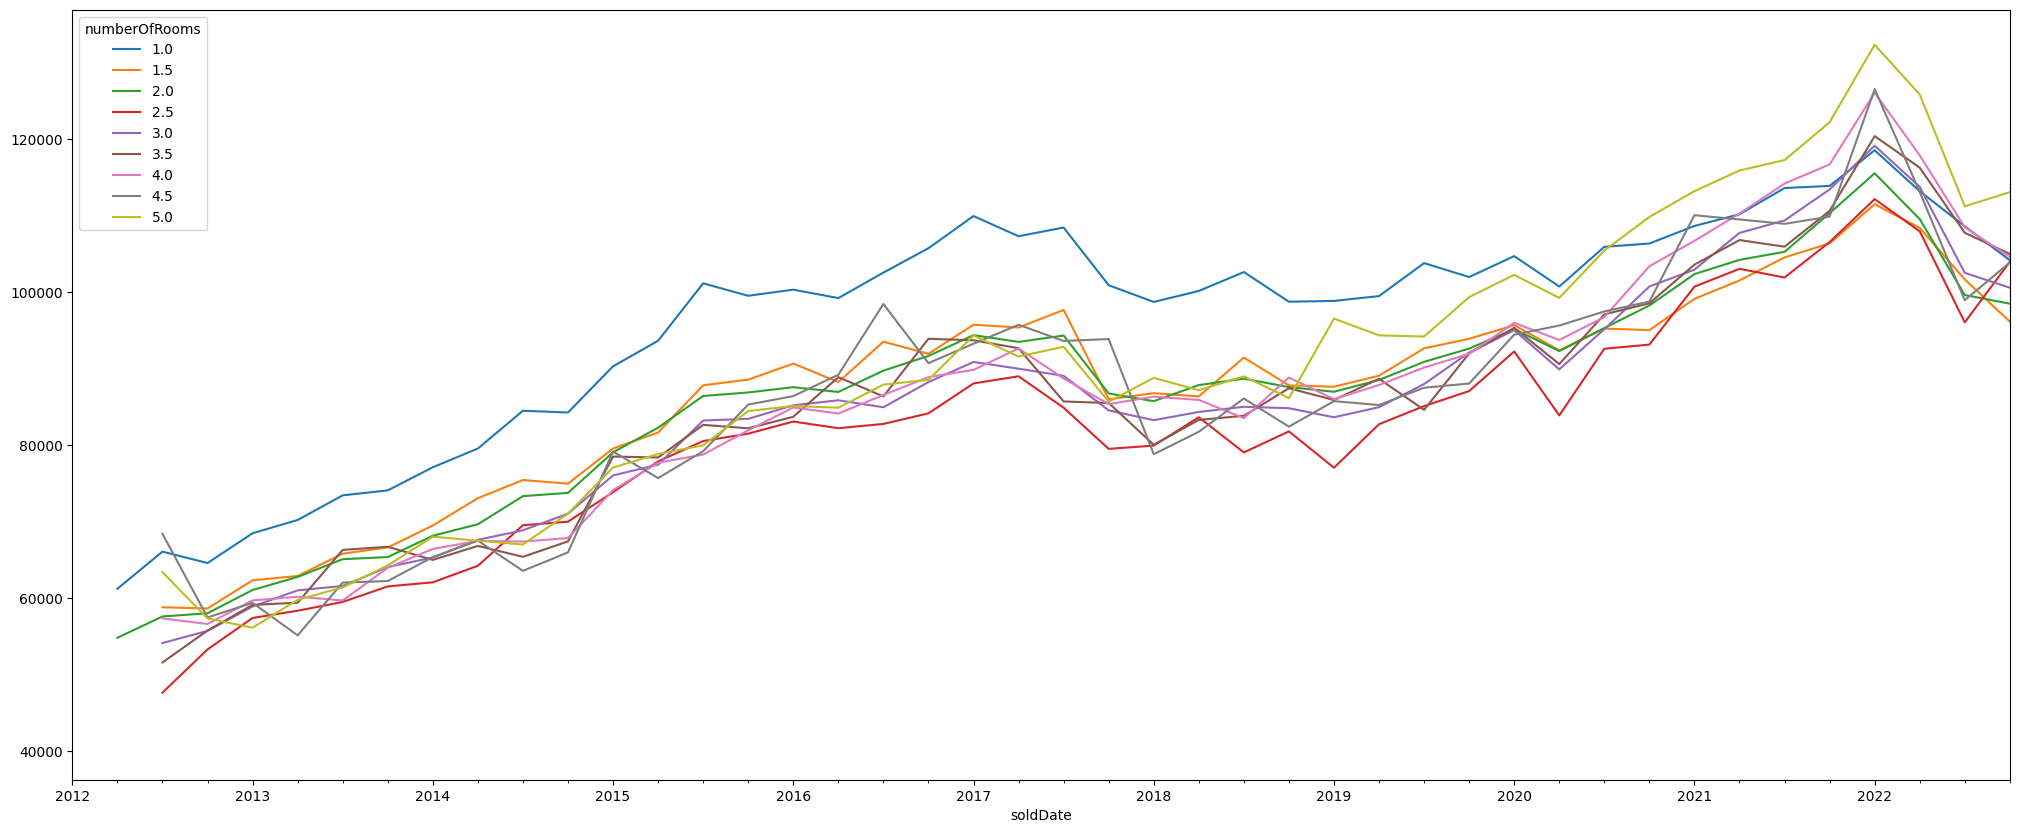

In [239]:
df_sqm_rooms = df[["soldDate", "soldSqmPriceInSek", "numberOfRooms"]].set_index("soldDate").groupby([pd.Grouper(freq = "Q"), "numberOfRooms"])["soldSqmPriceInSek"].mean().reset_index()
df_sqm_rooms = df_sqm_rooms[df_sqm_rooms.numberOfRooms <= 5]
df_sqm_rooms.pivot(index = "soldDate", columns = "numberOfRooms", values = "soldSqmPriceInSek").plot(kind = "line", figsize = (25, 10))

del df_sqm_rooms

### Rent

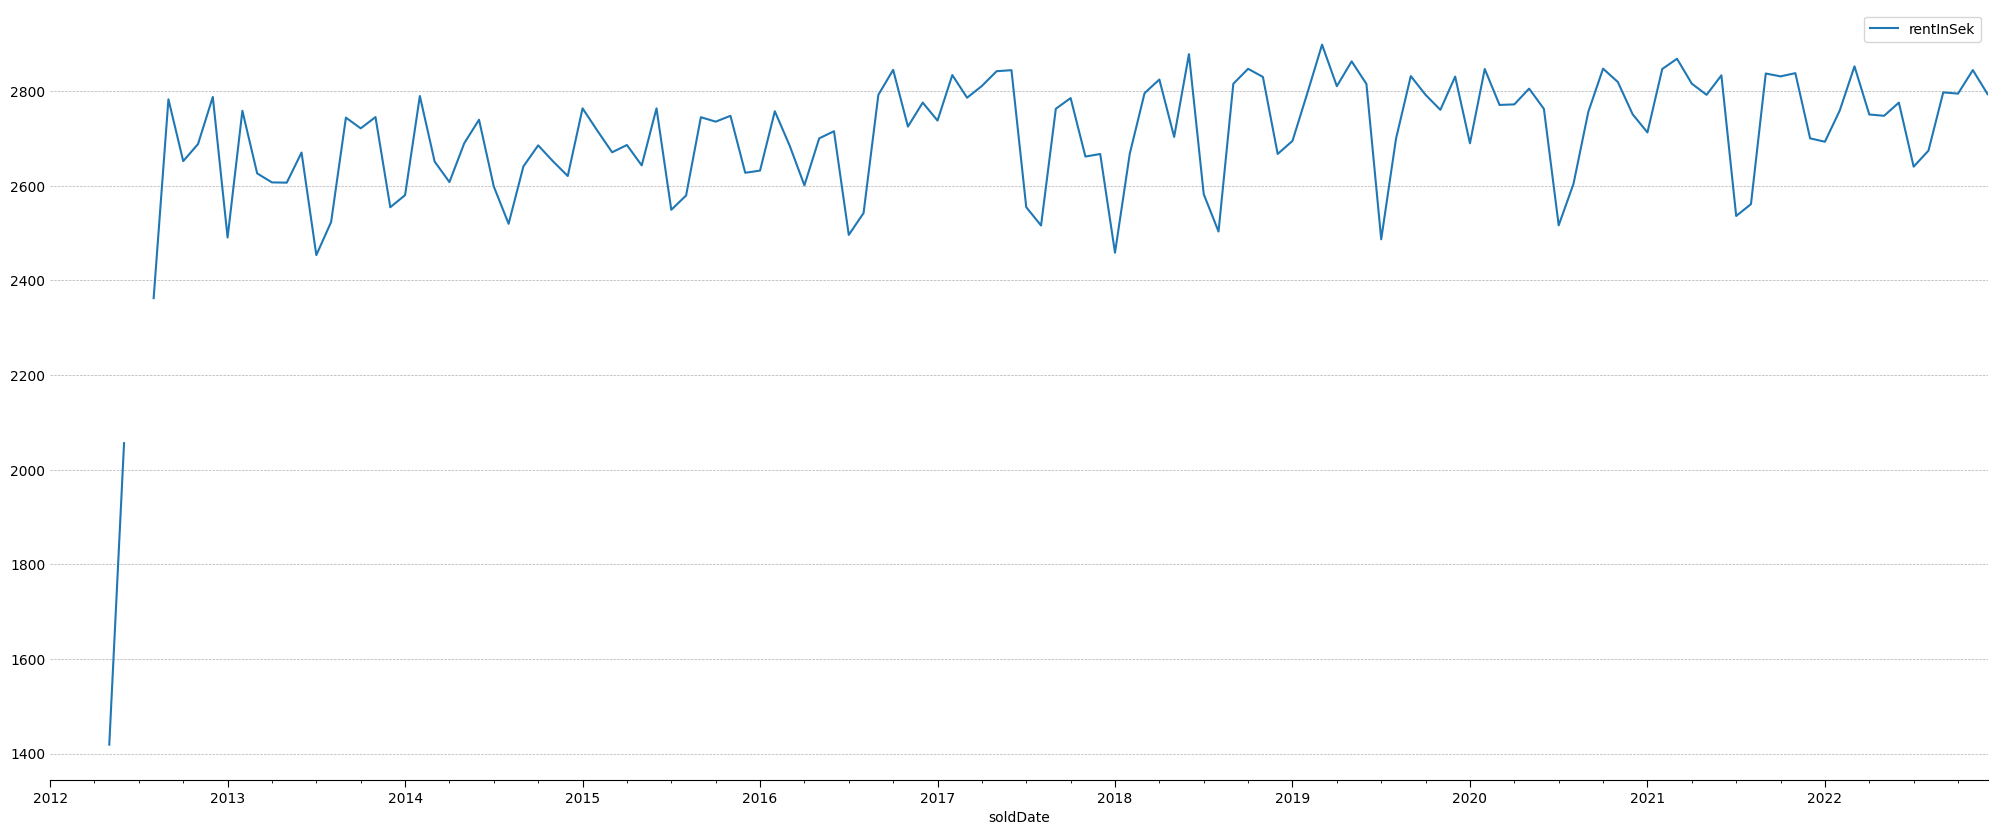

In [240]:
df_rent = df.copy()
plot_dates(df_rent, "soldDate", "rentInSek", "mean")

del df_rent

### Rent per Squared Meter

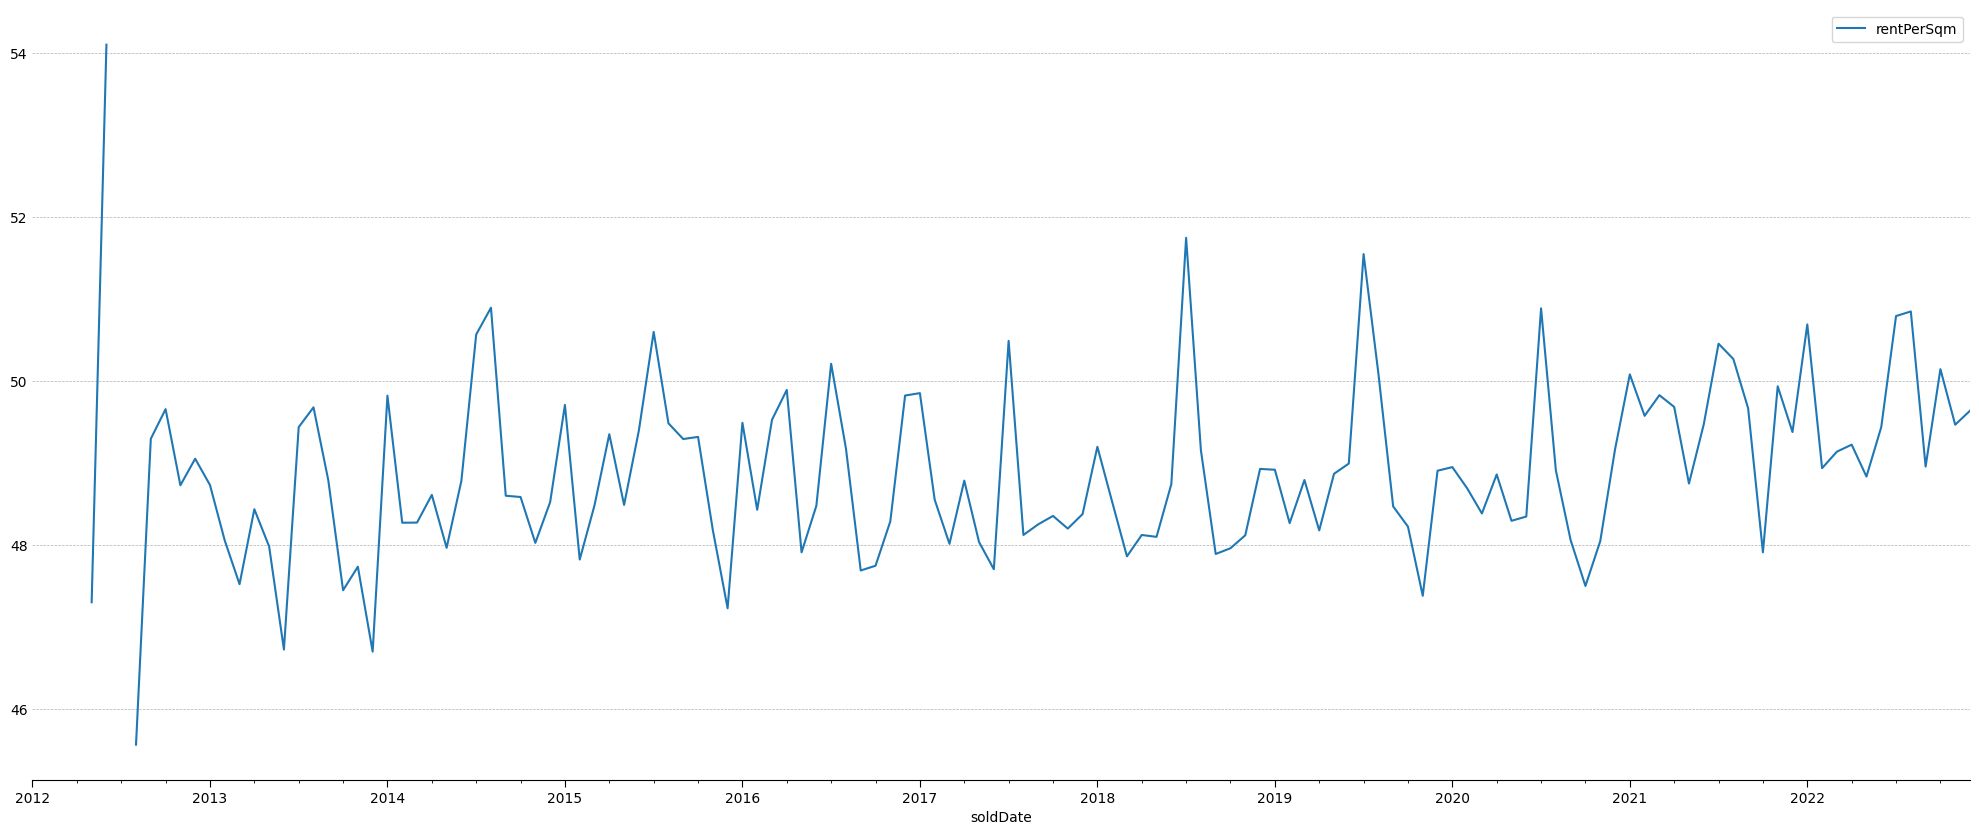

In [241]:
df_rentPerSqm = df.copy()
df_rentPerSqm["rentPerSqm"] = np.round(df_rentPerSqm.rentInSek / df_rentPerSqm.livingAreaInSqm, 1)
plot_dates(df_rentPerSqm, "soldDate", "rentPerSqm", "mean")

del df_rentPerSqm

### Squared Meter per Room

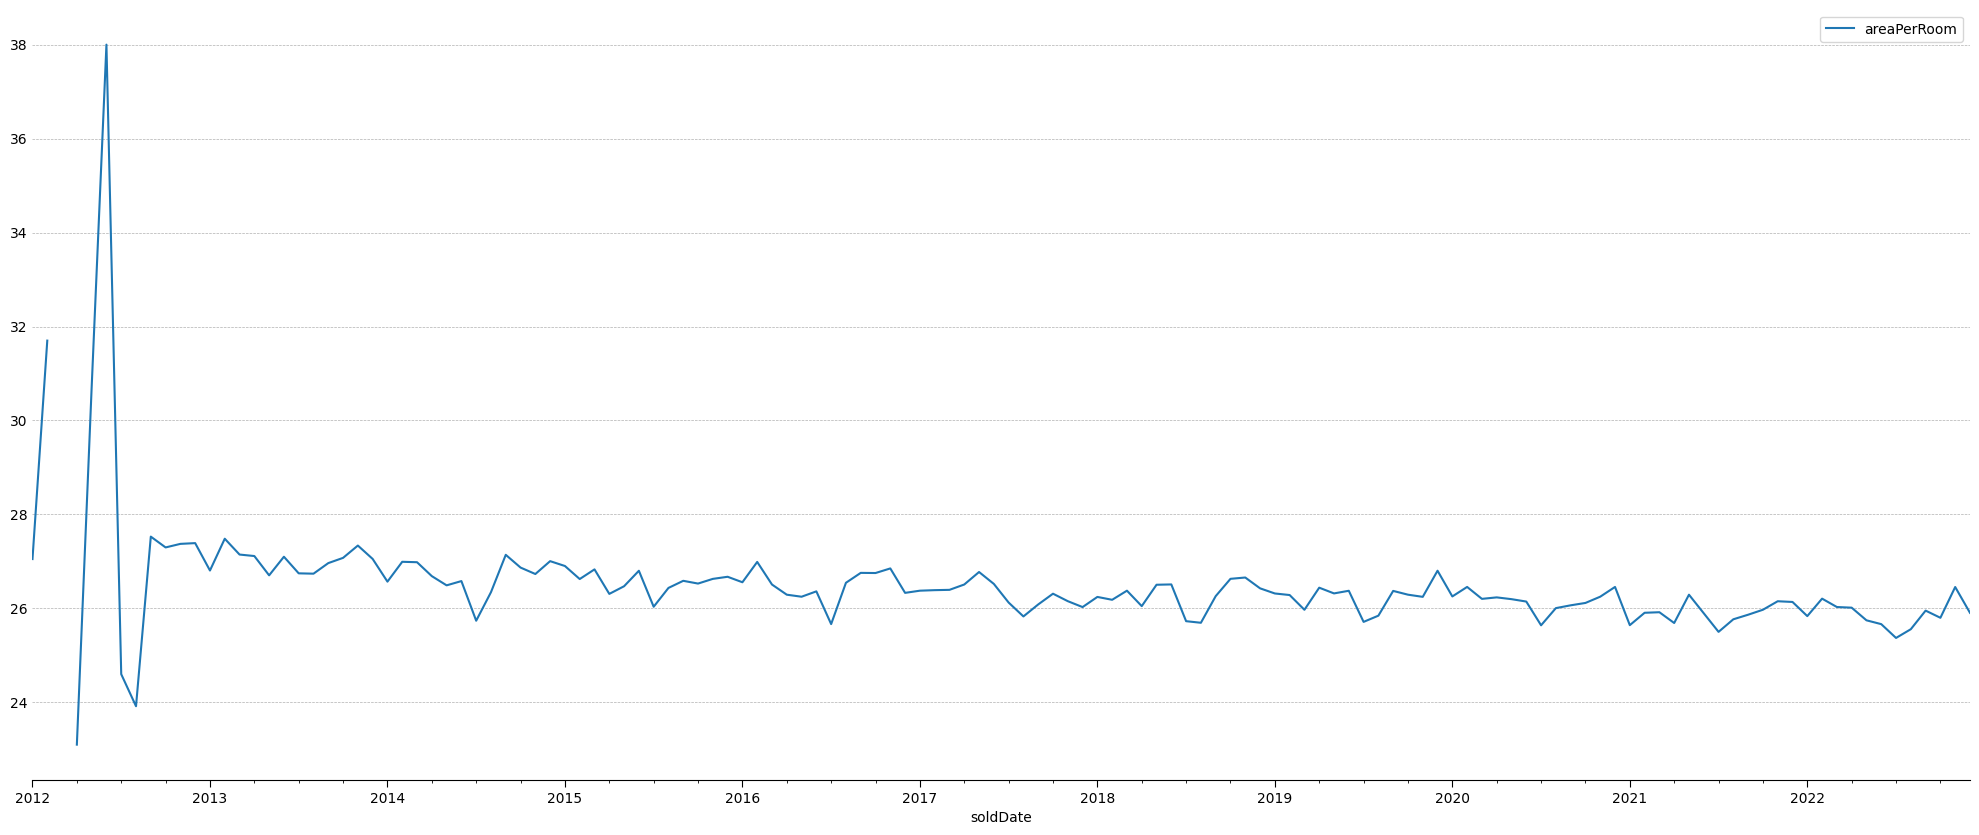

In [243]:
df_areaPerRoom = df.copy()
df_areaPerRoom["areaPerRoom"] = np.round(df_areaPerRoom.livingAreaInSqm / df_areaPerRoom.numberOfRooms, 1)
plot_dates(df_areaPerRoom, "soldDate", "areaPerRoom", "mean")

del df_areaPerRoom

### Monthly Average Sqm Price in Sek Per Descriptive Area Name

In [244]:
df[["descriptiveAreaName", "booliId"]].groupby(["descriptiveAreaName"]).count().sort_values(by = "booliId", ascending = False).head(30)

,booliId
descriptiveAreaName,
Vasastan,19035
Kungsholmen,18006
Södermalm,16341
Östermalm,10639
Gärdet,4097
Katarina,1457
Södermalm Katarina,1086
Essingeöarna,1056
Norrmalm,988


In [245]:
df_area_price = df[["soldDate", "descriptiveAreaName", "soldSqmPriceInSek"]].set_index("soldDate")
df_area_price = df_area_price[df_area_price.descriptiveAreaName.isin(["Vasastan", "Kungsholmen", "Södermalm", "Östermalm"])]
df_area_price = df_area_price[df_area_price.index >= "2012-12-31"]
df_area_price = df_area_price.groupby([pd.Grouper(freq = "M"), "descriptiveAreaName"]).mean().reset_index()
df_area_price = df_area_price.pivot(index = "soldDate", columns = "descriptiveAreaName", values = "soldSqmPriceInSek")
df_area_price["Mean"] = df_area_price.mean(axis = 1)

In [246]:
df_area_price.reset_index().head()

descriptiveAreaName,soldDate,Kungsholmen,Södermalm,Vasastan,Östermalm,Mean
0,2013-01-31,59320.109756,60340.608108,66087.478261,66009.318182,62939.378577
1,2013-02-28,56972.075269,59304.747253,65676.434783,67216.384615,62292.410480
2,2013-03-31,61103.741071,61005.252874,66525.214953,70012.962963,64661.792965
3,2013-04-30,61214.252525,62196.533333,67286.456311,69905.116279,65150.589612
4,2013-05-31,62088.827957,61526.765432,65177.415584,72397.000000,65297.502243


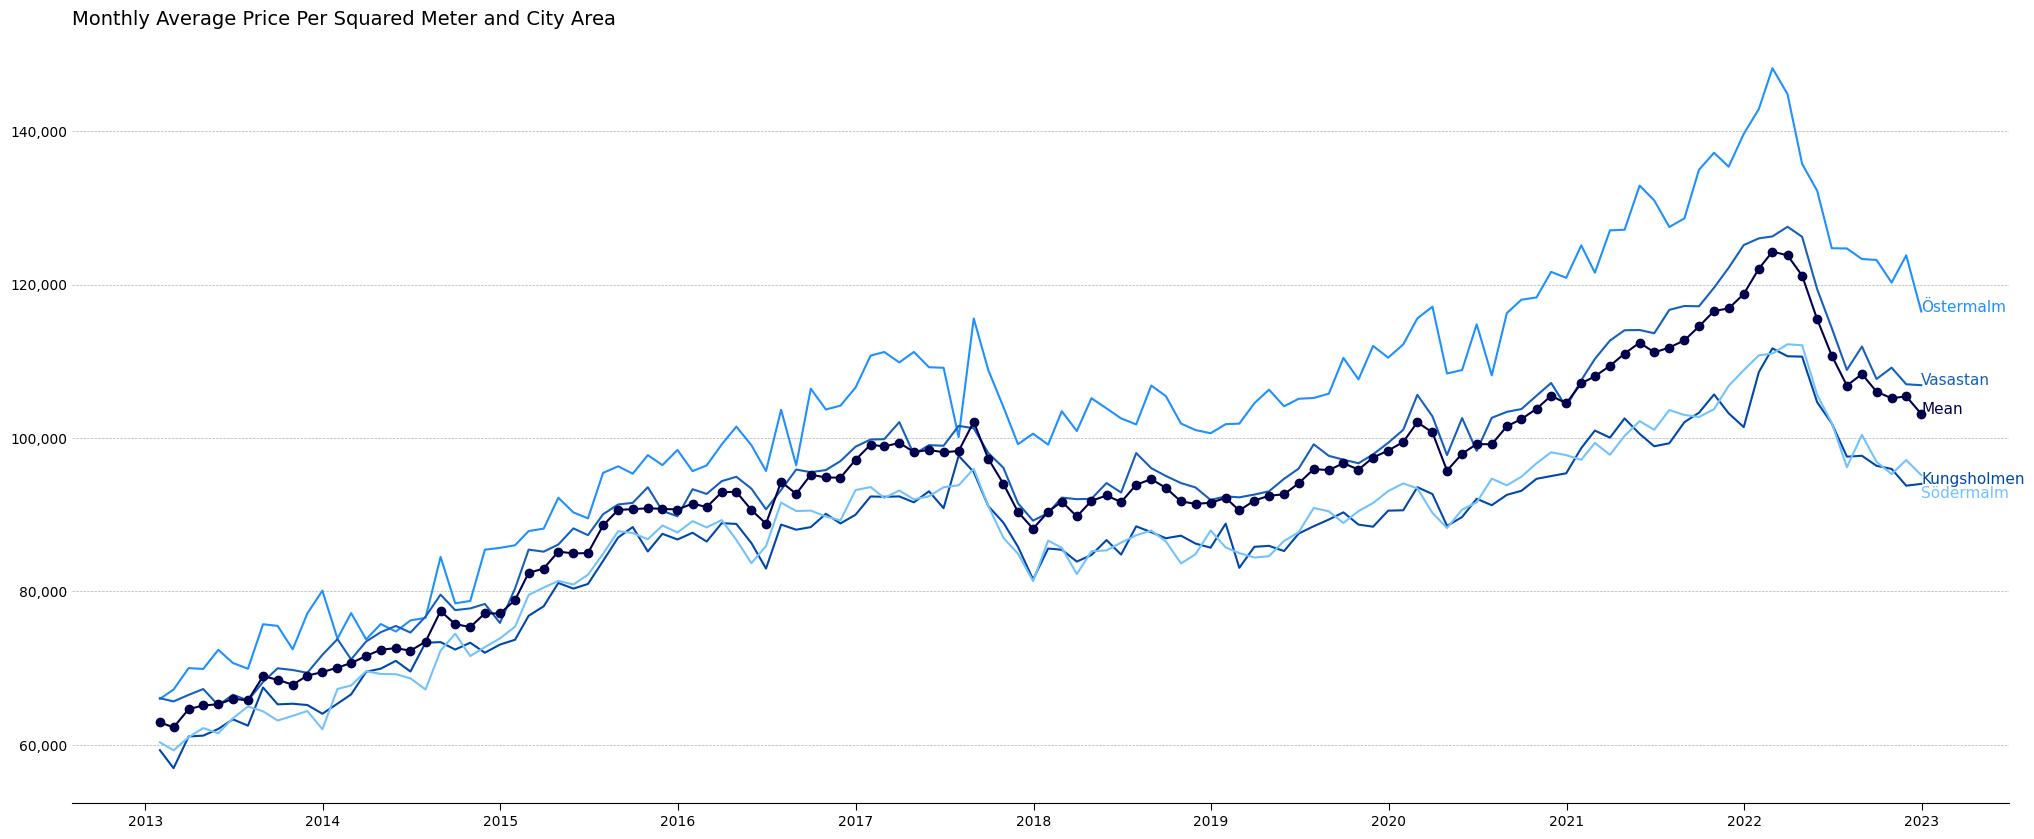

In [247]:
def plot_sqm_price_per_date(dataframe, ax):
    
    color_tableau = {
        "Kungsholmen": "#0047ab",
        "Östermalm": "#1E90FF",
        "Södermalm": "#73c2fb",
        "Vasastan": "#1560BD",
        "Mean": "#00004d"
    }
    
    temp = dataframe

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    for area, color in color_tableau.items():
        if area == "Mean":
            plt.plot(temp["soldDate"].values, 
                    temp[area].values, 
                    lw = 1.5,
                    linestyle = "-",
                    marker = "o",
                    color = color)
        else:
            plt.plot(temp["soldDate"].values, 
                    temp[area].values, 
                    lw = 1.5, 
                    color = color)
            
        y_pos = temp[area].values[-1] - 0.5
        if area == "Södermalm":    
            y_pos += -3000
            
        plt.text(temp.soldDate.max(), y_pos, area, fontsize = 11, color = color) 
            
    ax.set_title("Monthly Average Price Per Squared Meter and City Area", loc = "left", fontsize = 14)



plt.figure(figsize = (25, 10))
ax = plt.subplot(111)
plot_sqm_price_per_date(df_area_price.reset_index(), ax)

del df_area_price

#### Weighted Average

We are weighting 3 data points, the trailing data point, actual data point and leading data point with its corresponding weight. 
$$ WMA_{t} = \frac{w_{t-1} \cdot x_{t-1} + w_{t} \cdot x_{t} + w_{t+1} \cdot x_{t+1}}{w_{t-1} + w_{t} + w_{t+1}}$$

In [248]:
def plot_weighted_average(dataframe, ax):
    
    color_tableau = {
        "weightedAveragePriceInSek": "#00004d"
    }
    
    temp = dataframe
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    for area, color in color_tableau.items():
        if area == "weightedAveragePriceInSek":
            ax.plot(temp["soldDate"].values, 
                    temp[area].values, 
                    lw = 1.5,
                    linestyle = "-",
                    marker = "o",
                    color = color)
                  
        y_pos = temp[area].values[-1] - 1
            
        plt.text(temp.soldDate.max(), y_pos, area, fontsize = 11, color = color) 
            
    ax.set_title("Sold Sqm Price In Sek Weighted By Number of Objects Sold", loc = "left", fontsize = 14)

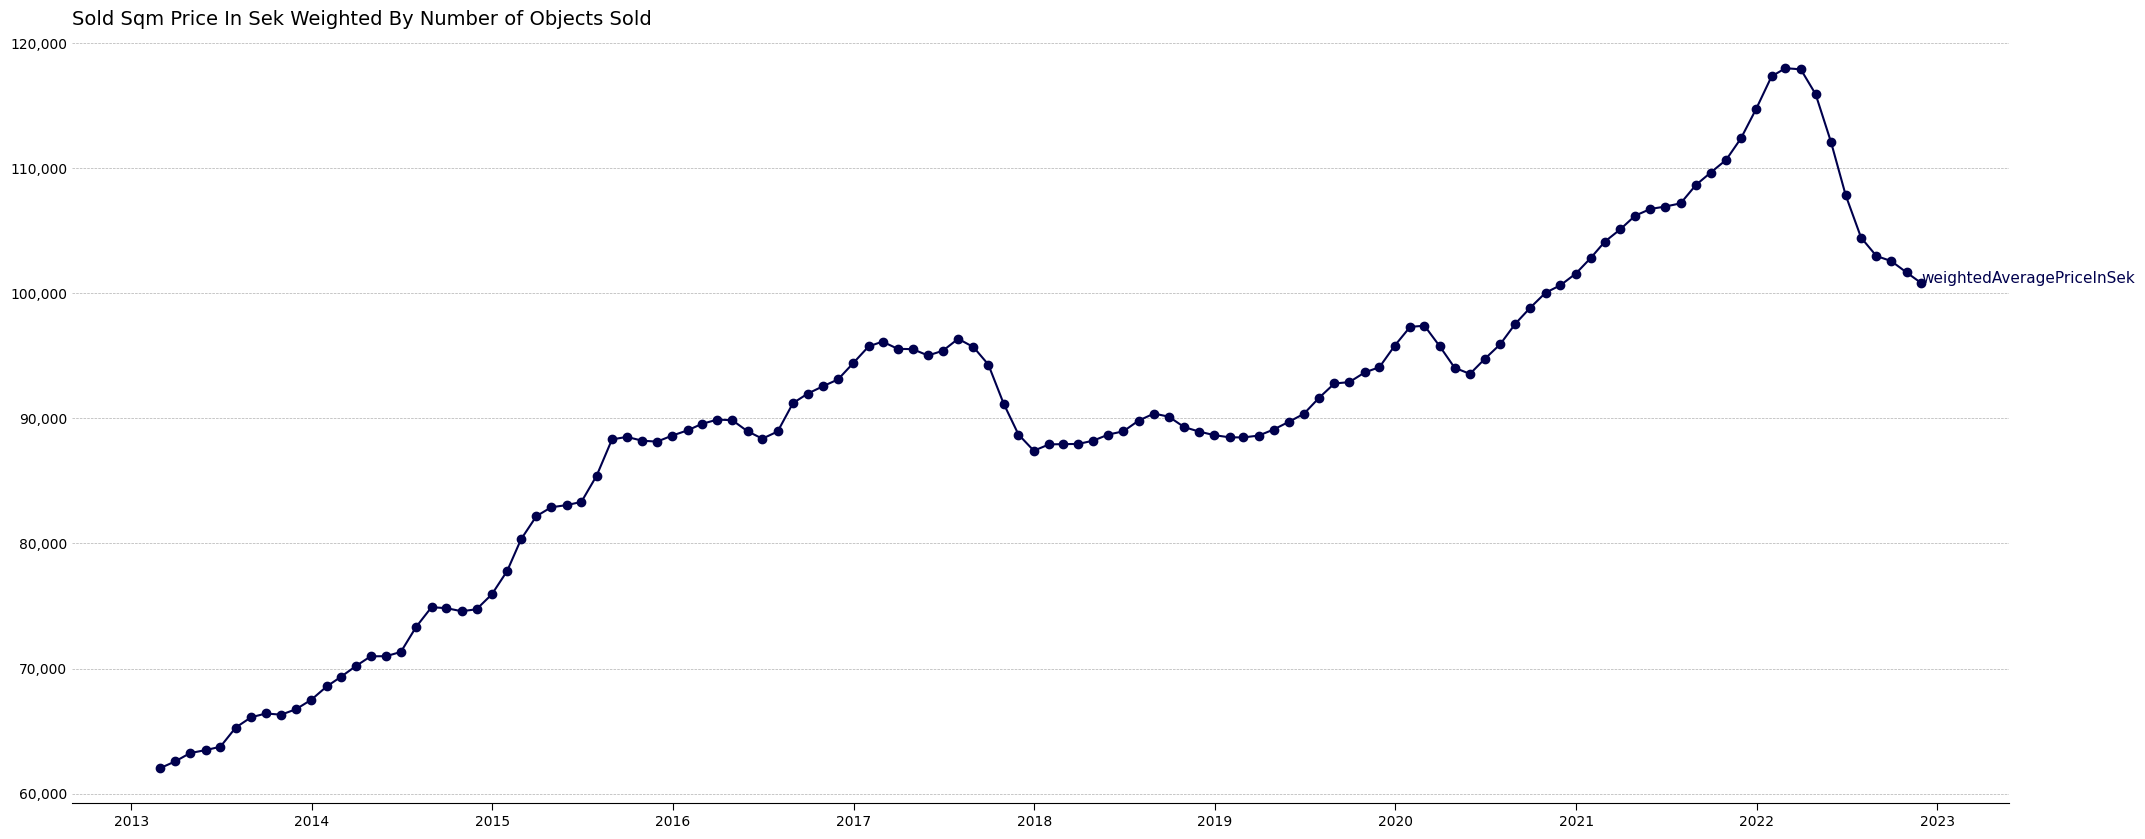

In [249]:
df_weighted_average = df.reset_index()[["soldDate", "booliId", "soldSqmPriceInSek"]].set_index("soldDate")
df_weighted_average = df_weighted_average[df_weighted_average.index >= "2012-12-31"]
df_weighted_average = df_weighted_average.groupby([pd.Grouper(freq = "M")]).agg({"booliId": "count", "soldSqmPriceInSek": "mean"}).rename(columns = {"booliId": "NumberOfSoldObjects", "soldSqmPriceInSek": "averagePriceInSek"})

for i in range(0, df_weighted_average.shape[0] - 2):
    df_weighted_average.loc[df_weighted_average.index[i + 1], "weightedAveragePriceInSek"] = np.round((
                                                                            df_weighted_average.iloc[i, 0] * df_weighted_average.iloc[i, 1] + 
                                                                            df_weighted_average.iloc[i + 1, 0] * df_weighted_average.iloc[i + 1, 1] + 
                                                                            df_weighted_average.iloc[i + 2, 0] * df_weighted_average.iloc[i + 2, 1]
                                                                        ) / (df_weighted_average.iloc[i, 0] + df_weighted_average.iloc[i + 1, 0] + df_weighted_average.iloc[i + 2, 0]), 1)
    
plt.figure(figsize = (25, 10))
ax = plt.subplot(111)
plot_weighted_average(df_weighted_average[:-1].reset_index(), ax)

del df_weighted_average

### Mean Sold Sqm Price in Sek & Inflation

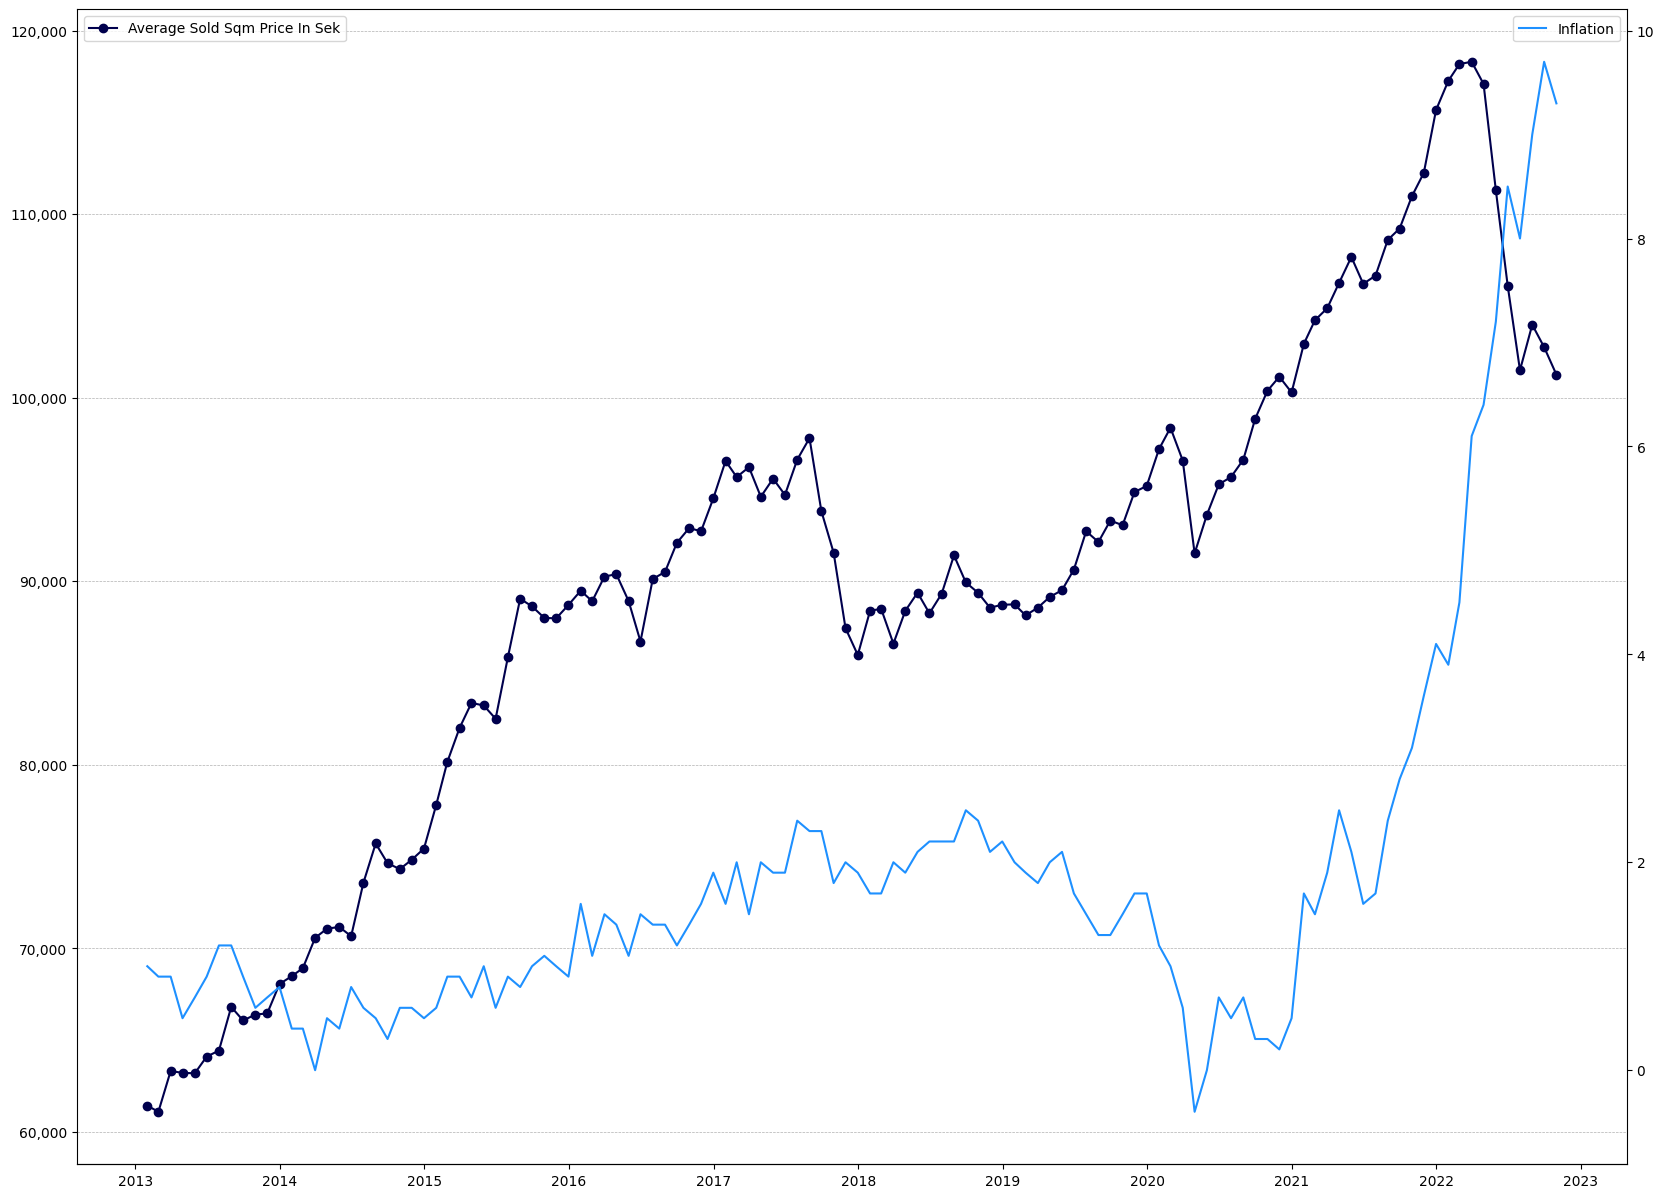

In [250]:
df_inflation_corr = df.reset_index()[["soldDate", "soldSqmPriceInSek", "CPIF"]].set_index("soldDate")
df_inflation_corr = df_inflation_corr[df_inflation_corr.index >= "2012-12-31"]
df_inflation_corr = df_inflation_corr.groupby([pd.Grouper(freq = "M")]).agg({"CPIF": "mean", "soldSqmPriceInSek": "mean"}).rename(columns = {"soldSqmPriceInSek": "averagePriceInSek"})
df_inflation_corr = df_inflation_corr[:-2]

fig, ax = plt.subplots(figsize = (25, 10))
ax2 = ax.twinx()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()  
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)

ax.plot(df_inflation_corr.averagePriceInSek, color = "#00004d", marker = "o")
ax2.plot(df_inflation_corr.CPIF, color = "#1E90FF")
ax.legend(["Average Sold Sqm Price In Sek"], loc = "upper left")
ax2.legend(["Inflation"])

del df_inflation_corr

## Change in Sold Sqm Price in Sek per Area

In [251]:
df_monthly_average = df.set_index("soldDate").groupby([pd.Grouper(freq = "M"), "descriptiveAreaName"])["soldSqmPriceInSek"].mean().reset_index()
df_ac = df_monthly_average[df_monthly_average.soldDate == "2022-11-30"][["descriptiveAreaName", "soldSqmPriceInSek"]].rename(columns = {"descriptiveAreaName": "Area", "soldSqmPriceInSek": "AC"})
df_ytd = df_monthly_average[df_monthly_average.soldDate == "2022-01-31"][["descriptiveAreaName", "soldSqmPriceInSek"]].rename(columns = {"descriptiveAreaName": "Area", "soldSqmPriceInSek": "YE start"})
df_py = df_monthly_average[df_monthly_average.soldDate == "2021-11-30"][["descriptiveAreaName", "soldSqmPriceInSek"]].rename(columns = {"descriptiveAreaName": "Area", "soldSqmPriceInSek": "PY"})

df_result = pd.merge(pd.merge(df_ac, df_ytd, on = "Area"), df_py, on = "Area")
df_result["AC vs PY"] = ((df_result.AC - df_result.PY) / df_result.PY) * 100
(df_result.style.format(precision = 0, formatter = {("AC vs PY"): lambda x: "{:,.1f}%".format(x) }))

del df_monthly_average, df_ac, df_ytd, df_py, df_result

## Construction Decades

### Sold Objects

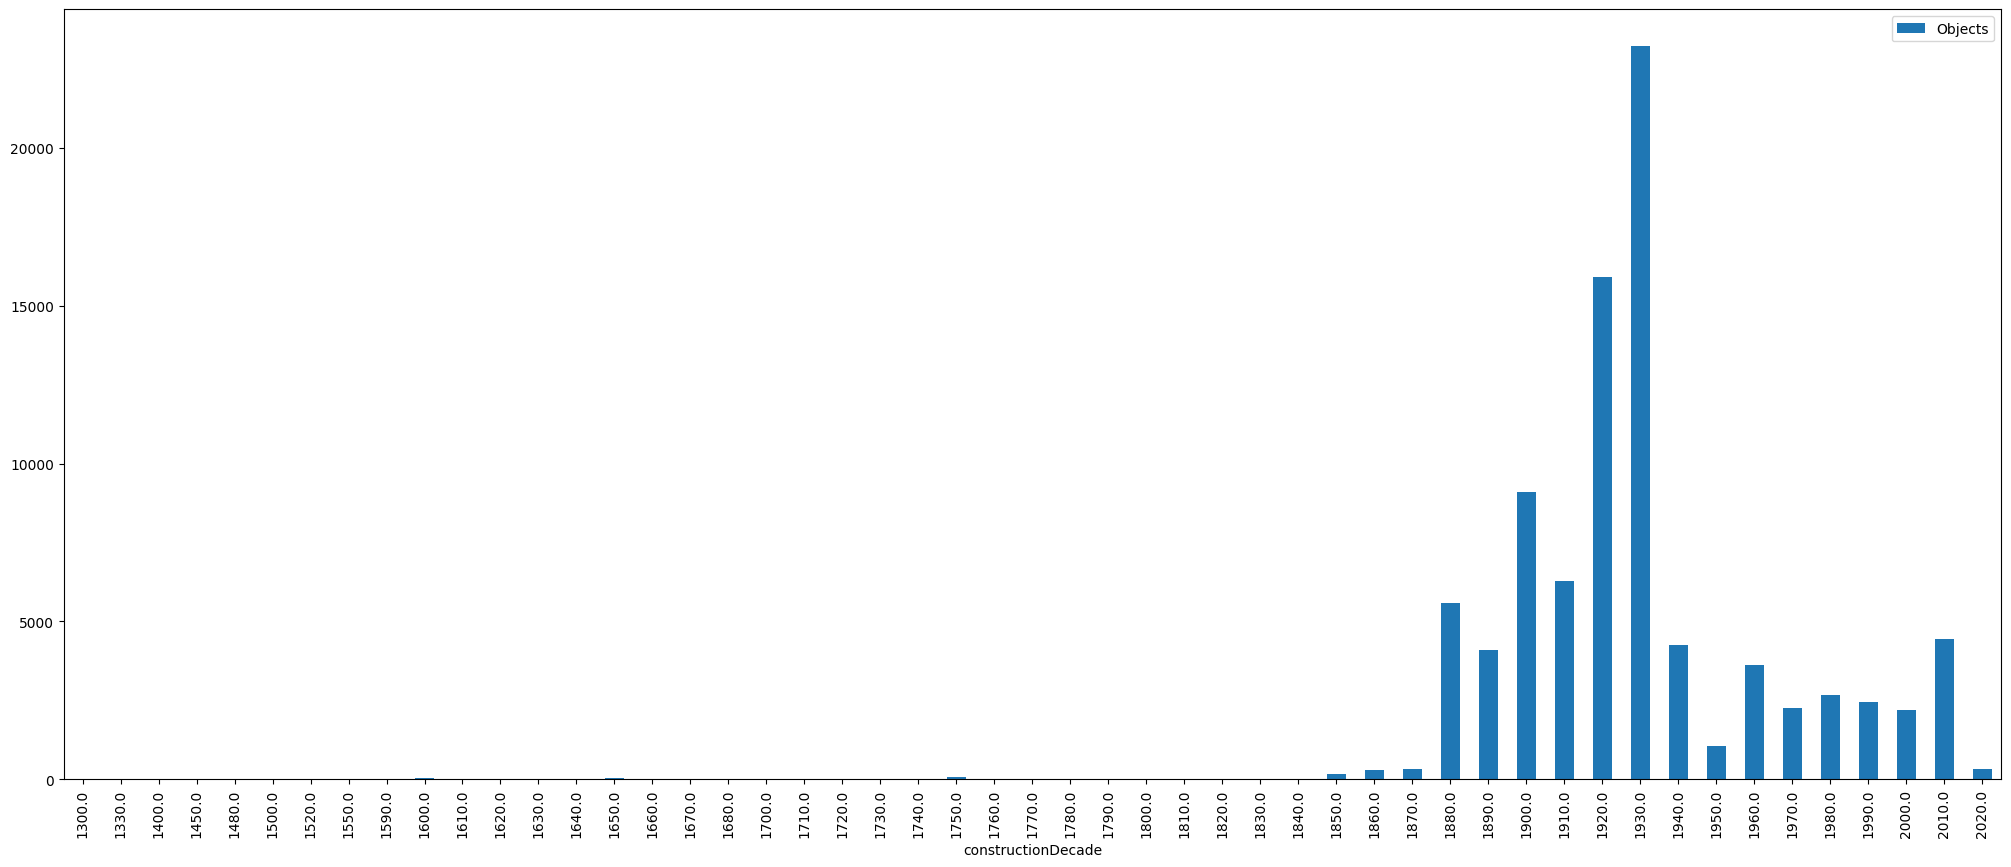

In [252]:
df_constructionDecade = df.copy()
df_constructionDecade["constructionDecade"] = (df_constructionDecade.constructionYear // 10) * 10
df_constructionDecade = df_constructionDecade[["constructionDecade", "booliId"]].groupby("constructionDecade").count().rename(columns = {"constructionDecade": "Decade", "booliId": "Objects"})
df_constructionDecade.plot(kind = "bar", figsize = (25, 10))

del df_constructionDecade

## Rent Categories

In [253]:
df_rentCategories = df.copy().set_index("soldDate")
bins = [
    0, 500, 
    1000, 1500, 
    2000, 2500, 
    3000, 3500, 
    4000, 4500, 
    5000, 5500, 
    6000, 6500, 
    100000
]
labels = [
    "0 - 500", 
    "500 - 1000", 
    "1000 - 1500", 
    "1500 - 2000", 
    "2000 - 2500", 
    "2500 - 3000", 
    "3000 - 3500", 
    "3500 - 4000", 
    "4000 - 4500", 
    "4500 - 5000", 
    "5000 - 5500",
    "5500 - 6000", 
    "6000 - 6500",
    ">6500"
]

df_rentCategories["rentCategories"] = pd.cut(df_rentCategories.rentInSek, bins = bins, include_lowest = True, labels = labels)


### Mean Quarterly Sold Sqm Price In Sek

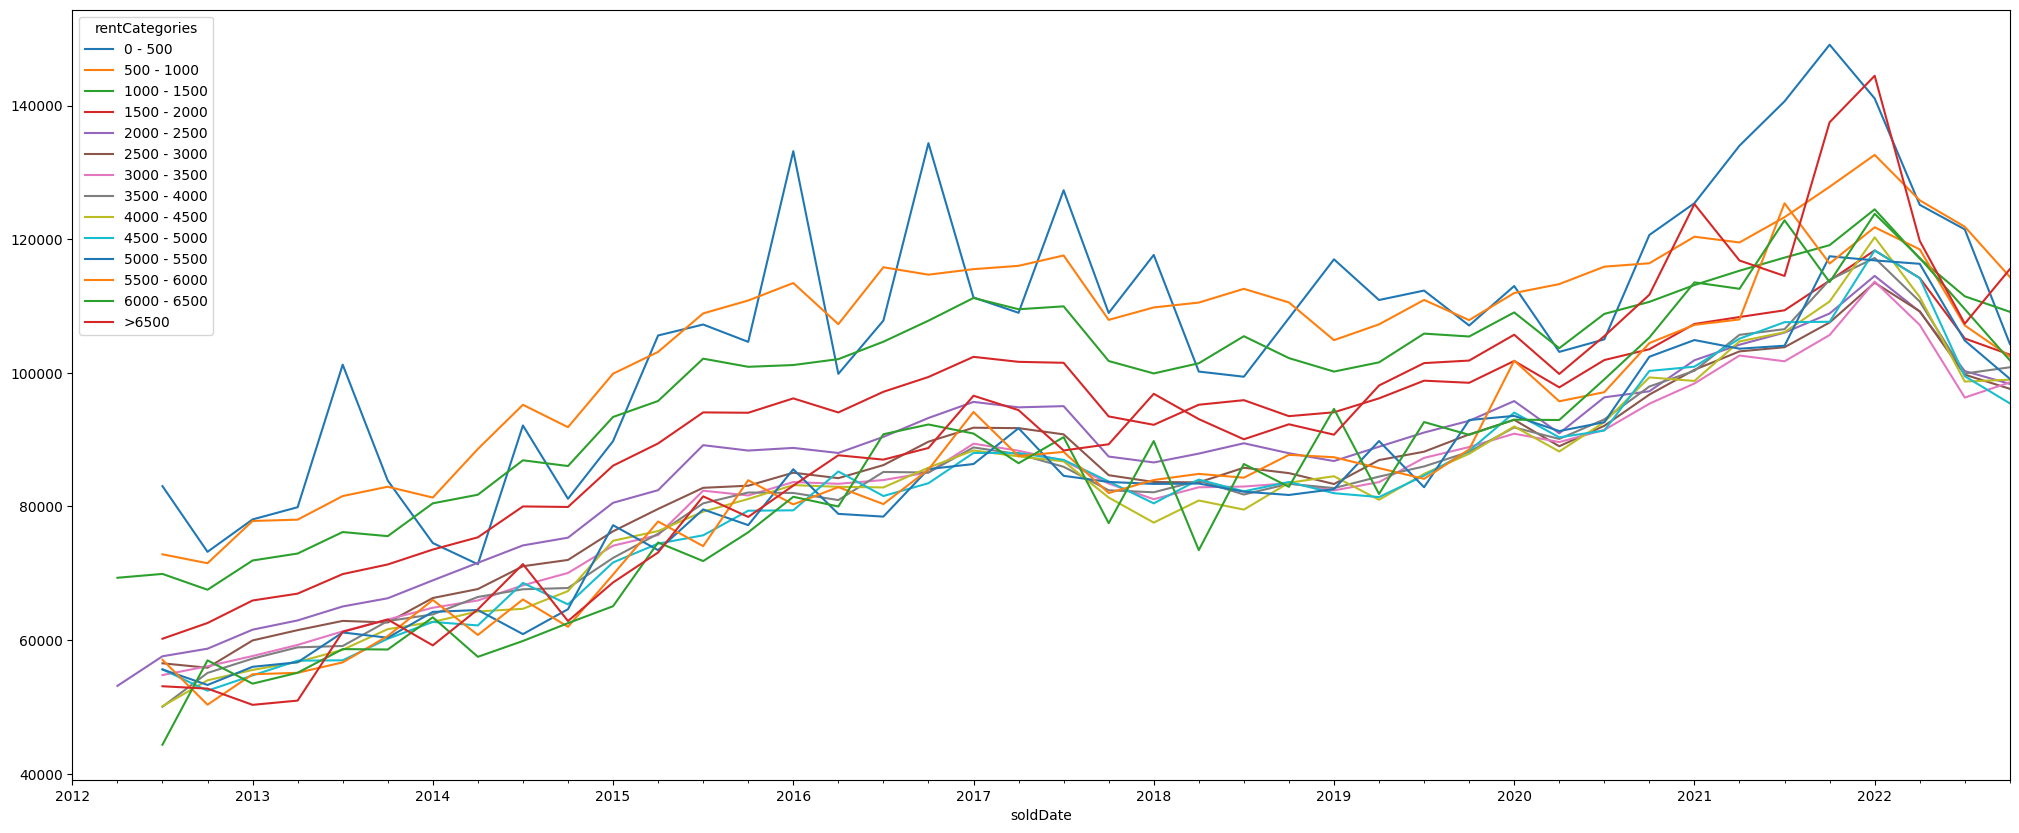

In [254]:
df_rentCategories = df_rentCategories[["rentCategories", "soldSqmPriceInSek"]].groupby([pd.Grouper(freq = "Q"), "rentCategories"]).mean().reset_index()

df_rentCategories.pivot(index = "soldDate", columns = "rentCategories", values = "soldSqmPriceInSek").plot(kind = "line", figsize = (25, 10))

del df_rentCategories

## Room Categories

In [255]:
df_roomCategories = df.copy().set_index("soldDate")
bins = [
    0, 1, 
    1.5, 2, 
    2.5, 3, 
    3.5, 4, 
    4.5, 5,   
    100
]
labels = [
    "0 - 1", 
    "1 - 1.5", 
    "1.5 - 2", 
    "2 - 2.5", 
    "2.5 - 3", 
    "3 - 3.5", 
    "3.5 - 4", 
    "4 - 4.5", 
    "4.5 - 5", 
    ">5"
]
df_roomCategories["roomCategories"] = pd.cut(df_roomCategories.numberOfRooms, bins = bins, include_lowest = True, labels = labels)

### Mean Quarterly Sold Sqm Price In Sek

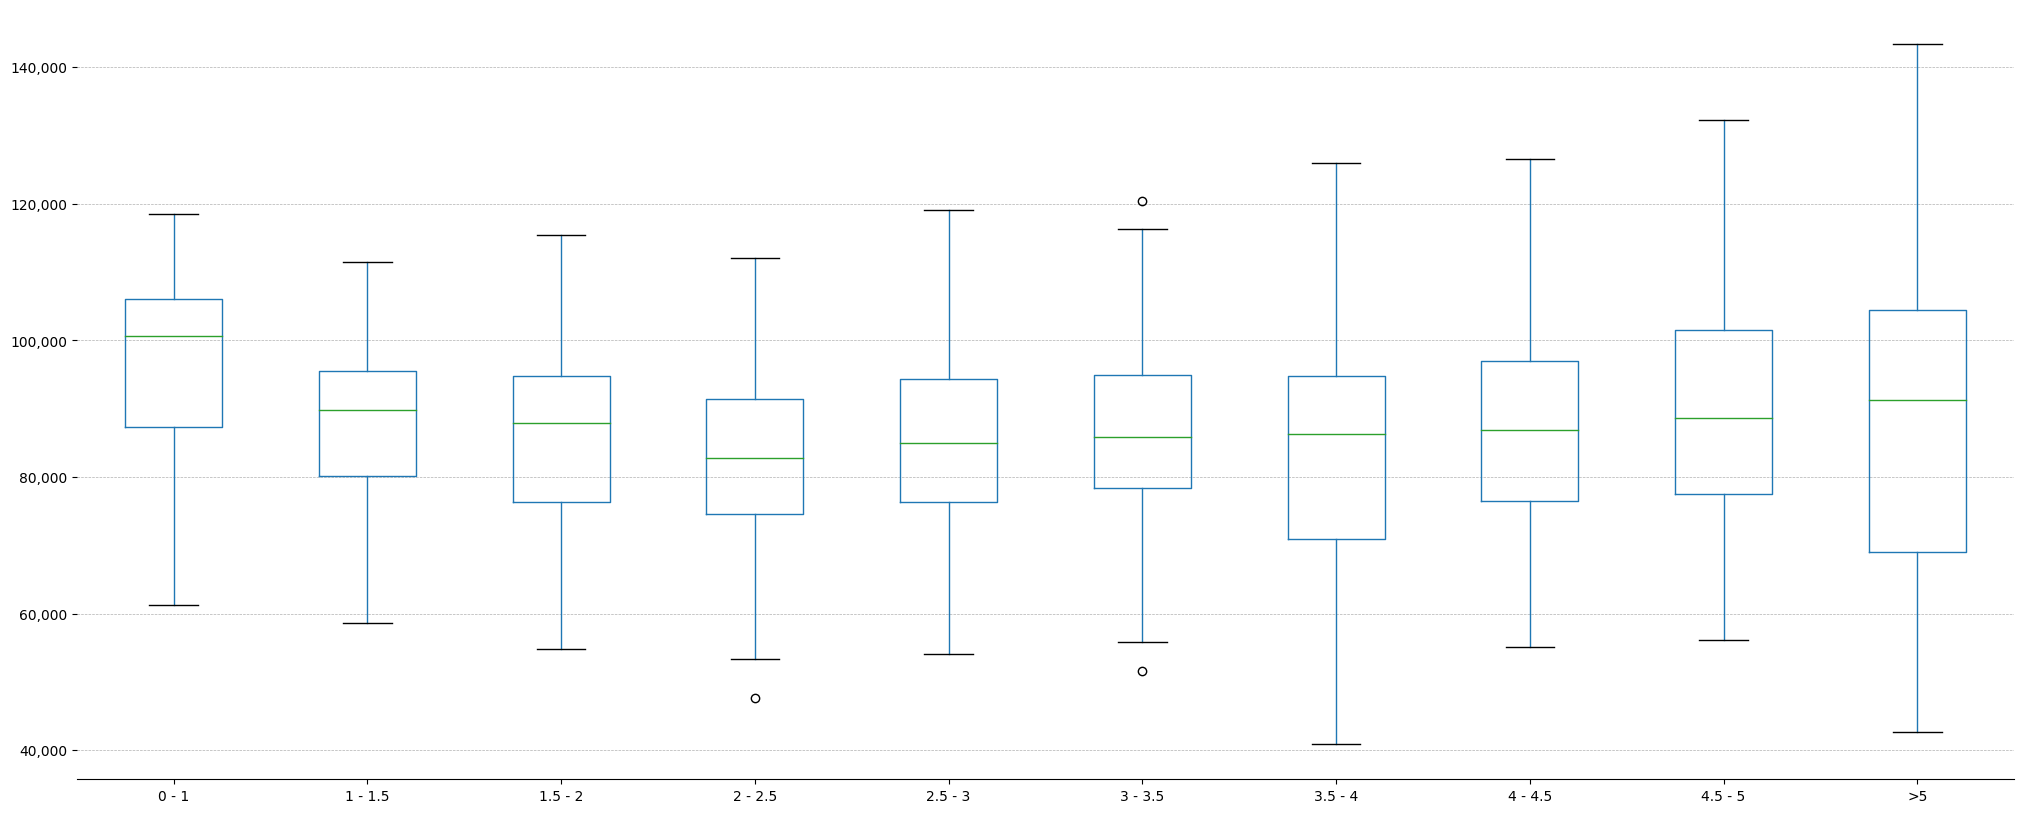

In [256]:
df_roomCategories = df_roomCategories[["roomCategories", "soldSqmPriceInSek"]].groupby([pd.Grouper(freq = "Q"), "roomCategories"]).mean().reset_index()
df_plot = df_roomCategories.pivot(index = "soldDate", columns = "roomCategories", values = "soldSqmPriceInSek").reset_index()

fig, ax = plt.subplots(figsize = (25, 10))
df_plot.boxplot()

# Plot grid and axis styles
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()  
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.grid(False)
ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)

del df_roomCategories

# 5. Data Cleaning

## Drop nan Columns

In [257]:
def get_nan_per_column(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(len(df))
    print('\n')
    print(missing_data)


get_nan_per_column(df)

97183


                                      Total   Percent
floorNumber                            9499  0.097743
constructionYear                       8632  0.088822
soldPriceVsListPriceDiffInPercentage   3752  0.038608
soldPriceVsListPriceDiffInSek          3752  0.038608
listPriceInSek                         3739  0.038474
CPIF                                   2177  0.022401
rentInSek                              1197  0.012317
daysActive                              590  0.006071
numberOfRooms                           248  0.002552
livingAreaInSqm                         149  0.001533
soldSqmPriceInSek                       149  0.001533
dateKey                                   0  0.000000
booliId                                   0  0.000000
streetAddress                             0  0.000000
url                                       0  0.000000
longitude                                 0  0.000000
latitude                                  0  0.000000
soldDate            

Calculating sold price vs list price in sek and in percentage since they can be calculated based on sold price and list price thus making sure that we dont drop rows that have missing values in these columns when sold och list price does exist.

In [258]:
df["soldPriceVsListPriceDiffInSek"] = df.soldPriceInSek - df.listPriceInSek
df["soldPriceVsListPriceDiffInPercentage"] = np.round(((df.soldPriceInSek - df.listPriceInSek) / df.listPriceInSek)*100, 1)

In [259]:
get_nan_per_column(df)

97183


                                      Total   Percent
floorNumber                            9499  0.097743
constructionYear                       8632  0.088822
listPriceInSek                         3739  0.038474
soldPriceVsListPriceDiffInPercentage   3739  0.038474
soldPriceVsListPriceDiffInSek          3739  0.038474
CPIF                                   2177  0.022401
rentInSek                              1197  0.012317
daysActive                              590  0.006071
numberOfRooms                           248  0.002552
livingAreaInSqm                         149  0.001533
soldSqmPriceInSek                       149  0.001533
dateKey                                   0  0.000000
booliId                                   0  0.000000
streetAddress                             0  0.000000
url                                       0  0.000000
longitude                                 0  0.000000
latitude                                  0  0.000000
soldDate            

In [260]:
df = df.dropna()
get_nan_per_column(df)

74855


                                      Total  Percent
booliId                                   0      0.0
streetAddress                             0      0.0
dateKey                                   0      0.0
floorNumber                               0      0.0
numberOfRooms                             0      0.0
livingAreaInSqm                           0      0.0
listPriceInSek                            0      0.0
soldPriceVsListPriceDiffInPercentage      0      0.0
soldPriceVsListPriceDiffInSek             0      0.0
soldSqmPriceInSek                         0      0.0
rentInSek                                 0      0.0
soldPriceInSek                            0      0.0
url                                       0      0.0
longitude                                 0      0.0
latitude                                  0      0.0
soldDate                                  0      0.0
daysActive                                0      0.0
soldPriceType                         

## Drop Dates with Few Data Points

In [261]:
df[["soldDate", "booliId"]].set_index("soldDate").groupby([pd.Grouper(freq = "M")])["booliId"].count().reset_index().sort_values("soldDate", ascending = True).head(30)


,soldDate,booliId
0,2012-05-31,1
1,2012-06-30,1
2,2012-07-31,0
3,2012-08-31,10
4,2012-09-30,67
5,2012-10-31,154
6,2012-11-30,149
7,2012-12-31,68
8,2013-01-31,189
9,2013-02-28,250


In [262]:
df = df[df.soldDate >= "2012-09-30"]
df = df.set_index("booliId")
df.sort_values("soldDate", ascending = True).head(30)

,streetAddress,constructionYear,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber,dateKey,CPIF
booliId,,,,,,,,,,,,,,,,,,,,,
1270221,Birkagatan 4,1927.0,Lägenhet,Vasastan,Sista bud,17.0,2012-09-30,59.339253,18.032454,/bostad/582830,3470000,2226.0,73830.0,375000.0,12.1,3095000.0,47.0,2.0,3.0,2012-09,0.9
1181045,Tulegatan 5B,1891.0,Lägenhet,Vasastan,Sista bud,17.0,2012-09-30,59.341318,18.062897,/annons/1181045,6425000,7141.0,53099.0,25000.0,0.4,6400000.0,121.0,4.0,4.0,2012-09,0.9
1271226,Essinge Brogata 22,1939.0,Lägenhet,Kungsholmen,Sista bud,16.0,2012-09-30,59.325085,18.004440,/annons/1271226,1320000,2109.0,44000.0,25000.0,1.9,1295000.0,30.0,1.0,1.0,2012-09,0.9
1270454,Birger Jarlsgatan 111C,1906.0,Lägenhet,Vasastan,Sista bud,16.0,2012-09-30,59.348773,18.058659,/annons/1270454,3550000,2369.0,61207.0,50000.0,1.4,3500000.0,58.0,2.0,2.0,2012-09,0.9
1273715,Strålgatan 23,1938.0,Lägenhet,Kungsholmen,Sista bud,12.0,2012-09-30,59.324080,18.005720,/bostad/752081,1600000,2259.0,50000.0,100000.0,6.7,1500000.0,32.0,1.0,3.0,2012-09,0.9
1263985,Bysistorget 6,1932.0,Lägenhet,Södermalm,Sista bud,24.0,2012-09-30,59.318382,18.055773,/annons/1263985,2600000,1841.0,59908.0,5000.0,0.2,2595000.0,43.4,2.0,2.0,2012-09,0.9
1265007,Observatoriegatan 9,1881.0,Lägenhet,Vasastan,Sista bud,24.0,2012-10-01,59.340581,18.051606,/annons/1265007,3400000,3065.0,57627.0,-200000.0,-5.6,3600000.0,59.0,2.0,2.0,2012-10,1.1
1272464,Upplandsgatan 19B,1887.0,Lägenhet,Vasastan,Sista bud,16.0,2012-10-02,59.338388,18.052430,/annons/1272464,5000000,4230.0,59524.0,-500000.0,-9.1,5500000.0,84.0,2.0,4.0,2012-10,1.1
1269285,Dalagatan 23,1882.0,Lägenhet,Vasastan,Sista bud,19.0,2012-10-02,59.343334,18.043790,/annons/1269285,5810000,2493.0,65281.0,10000.0,0.2,5800000.0,89.0,3.5,2.0,2012-10,1.1


# 6. Saving Cleaned Data to Pickle

In [263]:
# parquet_file = df.to_parquet(index = False)
# azure_utils.upload_csv_to_datalake(df, f"silver/sold_clean", f"Sold_{date.today()}.csv")
df.to_pickle("cleaned.pkl")

In [264]:
del df